<h3  style = "color: skyblue" >Importing Libraries<h3>

In [115]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import optuna
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve


import warnings
warnings.filterwarnings('ignore')
sns.set_style('ticks')

<h3  style = "color: skyblue" >Data Ingestion and Loading<h3>

In [2]:
customers = pd.read_csv("../data/customers.csv")
loans = pd.read_csv("../data/loans.csv")
bureau = pd.read_csv("../data/bureau_data.csv")

print("The number of row and columns for each dataset:\n")
print(f"Customer dataset: {customers.shape}")
print(f"Loans dataset: {loans.shape}")
print(f"Bureau dataset: {bureau.shape}")

The number of row and columns for each dataset:

Customer dataset: (50000, 12)
Loans dataset: (50000, 15)
Bureau dataset: (50000, 8)


<h3 style = "color: skyblue">Data Merging</h3> 

 We merge all three datasets using the cust_id key to create a single modeling dataset

In [3]:
# Merge customers and loans
df = pd.merge(left= customers, right= loans, on="cust_id")

# Merge with bureau data
df = pd.merge(left= df, right= bureau, on="cust_id")

df.head(2)

,cust_id,age,gender,marital_status,employment_status,income,number_of_dependants,residence_type,years_at_current_address,city,...,disbursal_date,installment_start_dt,default,number_of_open_accounts,number_of_closed_accounts,total_loan_months,delinquent_months,total_dpd,enquiry_count,credit_utilization_ratio
0,C00001,44,M,Married,Self-Employed,2586000,3,Owned,27,Delhi,...,2019-07-24,2019-08-10,False,1,1,42,0,0,3,7
1,C00002,38,M,Married,Salaried,1206000,3,Owned,4,Chennai,...,2019-07-24,2019-08-15,False,3,1,96,12,60,5,4


<h3 style = "color:skyblue" >Data Overview</h3>

We inspect data types, missing values, and column information using df.info()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cust_id                      50000 non-null  object 
 1   age                          50000 non-null  int64  
 2   gender                       50000 non-null  object 
 3   marital_status               50000 non-null  object 
 4   employment_status            50000 non-null  object 
 5   income                       50000 non-null  int64  
 6   number_of_dependants         50000 non-null  int64  
 7   residence_type               49938 non-null  object 
 8   years_at_current_address     50000 non-null  int64  
 9   city                         50000 non-null  object 
 10  state                        50000 non-null  object 
 11  zipcode                      50000 non-null  int64  
 12  loan_id                      50000 non-null  object 
 13  loan_purpose    

<h3 style = "color: skyblue">Target Variable Conversion</h3>

The target variable default is converted to integer type for modeling.

In [5]:
df.default.unique()

array([False,  True])

In [6]:
# changing the datatype of target variable
df['default'] = df['default'].astype(int)
df.default.unique()

array([0, 1])

In [7]:
df.default.value_counts()

default
0    45703
1     4297
Name: count, dtype: int64

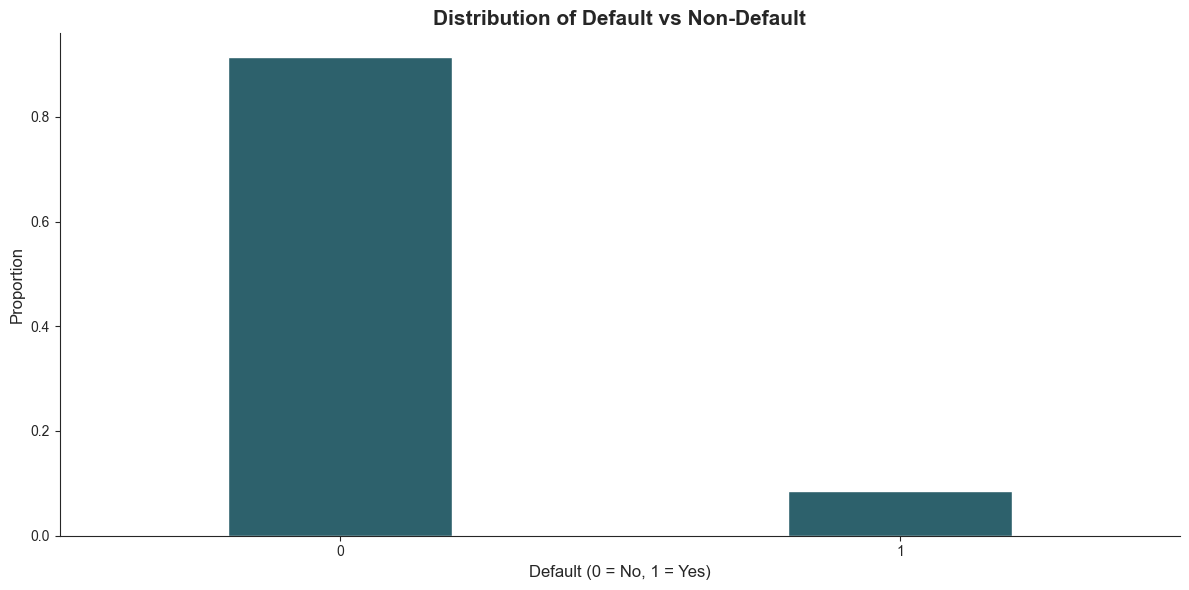

In [8]:
## visulization of Target variable
plt.figure(figsize=(12,6))
sns.barplot(df.default.value_counts(normalize=True), width=0.4, color="#226876")
plt.title("Distribution of Default vs Non-Default", fontsize=15, fontweight='bold')
plt.xlabel("Default (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

The chart shows that the majority of customers did not default, while a small percentage (around 8–9%) did.
This indicates that the dataset is imbalanced, We will address it later on.

<h3 style = "color:skyblue">Train-Test Split</h3>

To prevent data leakage, we split the data before performing EDA.

In [9]:
X = df.drop(columns=["default"])
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


print("Shape after splitting:")
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")


Shape after splitting:
Train: (37500, 33)
Test: (12500, 33)


<h3 style = "color:skyblue">Handling missing values</h3>

Impute categorical missing values using the mode.

In [10]:
df_train.isna().sum()[:20]

cust_id                      0
age                          0
gender                       0
marital_status               0
employment_status            0
income                       0
number_of_dependants         0
residence_type              48
years_at_current_address     0
city                         0
state                        0
zipcode                      0
loan_id                      0
loan_purpose                 0
loan_type                    0
sanction_amount              0
loan_amount                  0
processing_fee               0
gst                          0
net_disbursement             0
dtype: int64

In [11]:
df_train['residence_type'].unique()

array(['Owned', 'Mortgage', 'Rented', nan], dtype=object)

In [12]:
#mode
df_train.residence_type.mode()[0]

'Owned'

In [13]:
## Imputing the value with mode, wasting data is sin

df_train['residence_type'] = df['residence_type'].fillna(df.residence_type.mode()[0])

In [14]:
df_train['residence_type'].unique()

array(['Owned', 'Mortgage', 'Rented'], dtype=object)

In [15]:
# Do the same thing for the test data

df_test.residence_type.unique()

array(['Owned', 'Rented', 'Mortgage', nan], dtype=object)

In [16]:
df_test['residence_type'] = df_test['residence_type'].fillna(df_test['residence_type'].mode()[0])

In [17]:
df_test.residence_type.unique()

array(['Owned', 'Rented', 'Mortgage'], dtype=object)

<h3 style = "color: skyblue">Checking for dulpicates</h3>

In [18]:

print("Duplicate rows in train:", df_train.duplicated().sum())
print("Duplicate rows in test:", df_test.duplicated().sum())


Duplicate rows in train: 0
Duplicate rows in test: 0


<h3 style = "color: skyblue">Segregating Numeric and Categorical Columns</h3>

In [19]:
df_train.columns

Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
       'income', 'number_of_dependants', 'residence_type',
       'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
       'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'disbursal_date', 'installment_start_dt', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio', 'default'],
      dtype='object')

In [20]:
columns_numeric = ['age', 'income', 'number_of_dependants', 'years_at_current_address', 'sanction_amount', 'loan_amount', 'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months', 'principal_outstanding', 'bank_balance_at_application', 'number_of_open_accounts', 'number_of_closed_accounts', 'total_loan_months', 'delinquent_months', 'total_dpd', 'enquiry_count', 'credit_utilization_ratio']

columns_categorical = ['gender', 'marital_status', 'employment_status', 'residence_type', 'state', 'zipcode', 'loan_purpose', 'loan_type', 'default']

<h3 style = "color:skyblue">Outlier Detection Using Boxplots</h3>

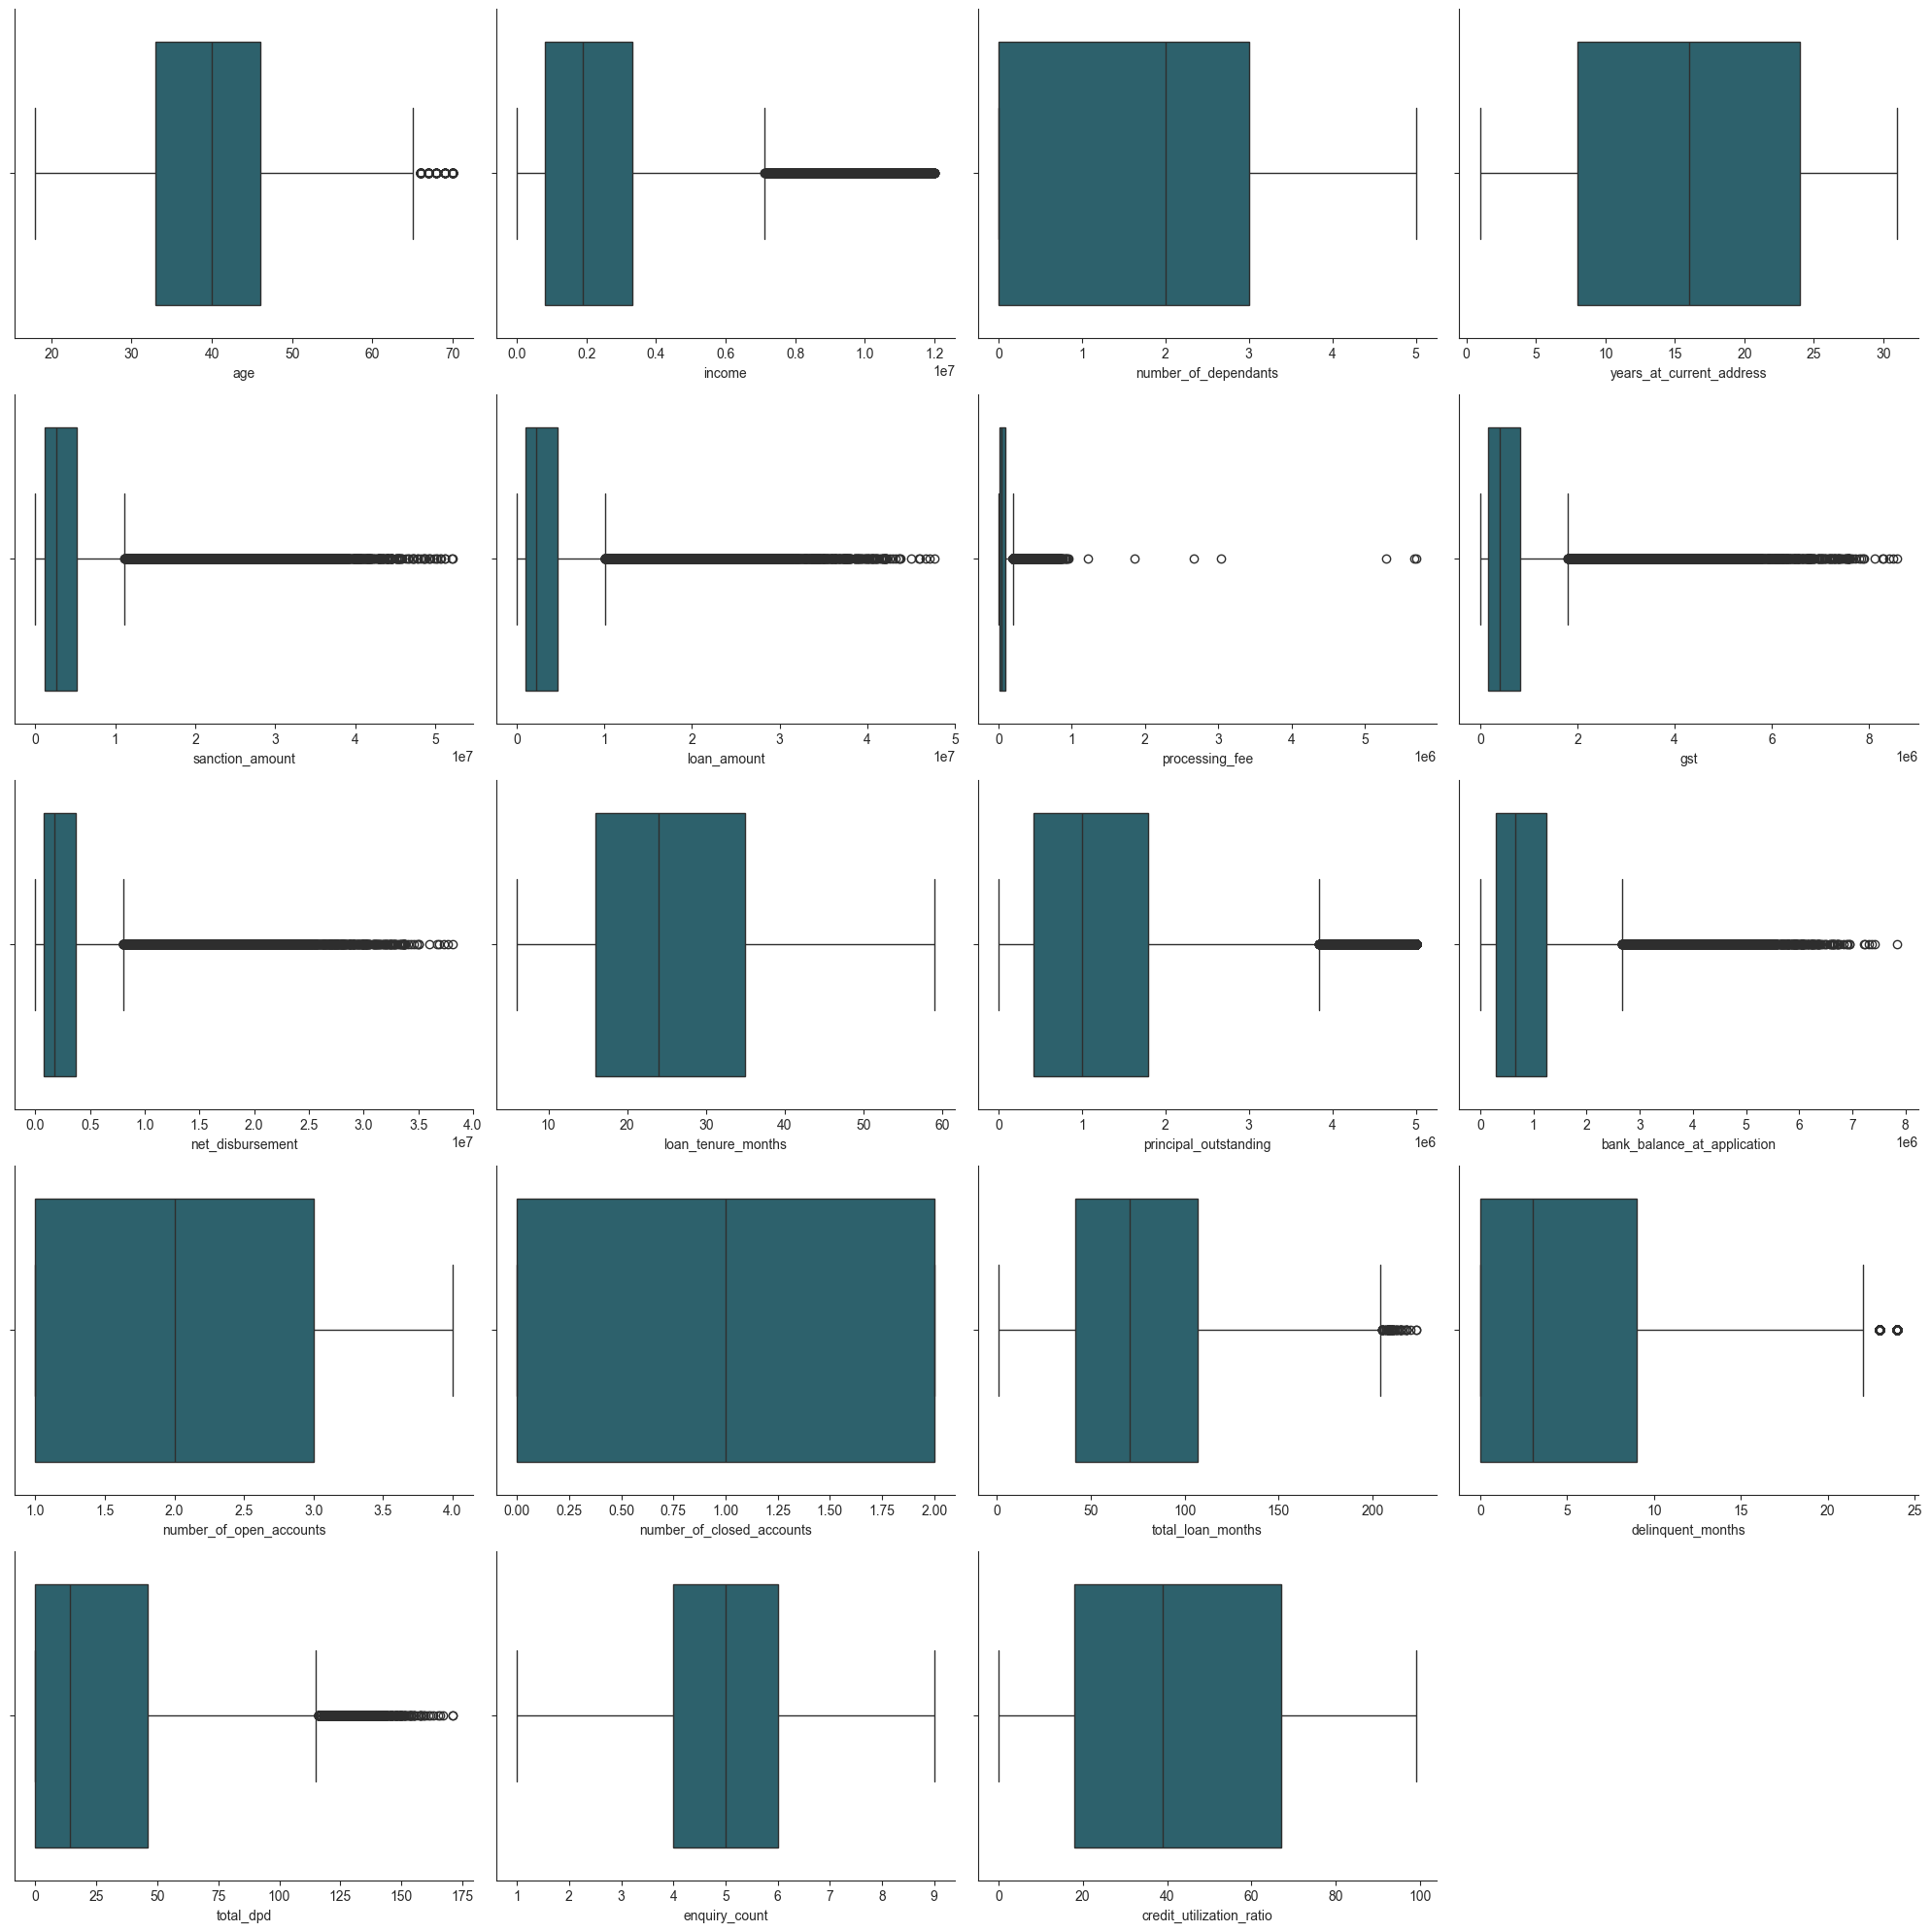

In [21]:
plt.figure(figsize=(20, 20))  # adjust overall figure size

# Loop through numeric columns and create subplots (4 per row)
for i, col in enumerate(columns_numeric, 1):
    plt.subplot(math.ceil(len(columns_numeric) / 4), 4, i)
    sns.boxplot(x=df_train[col], color="#226876")
    

plt.tight_layout()
sns.despine()
plt.show()


<h3 style = "color:skyblue">Distribution of Numeric Columns</h3>

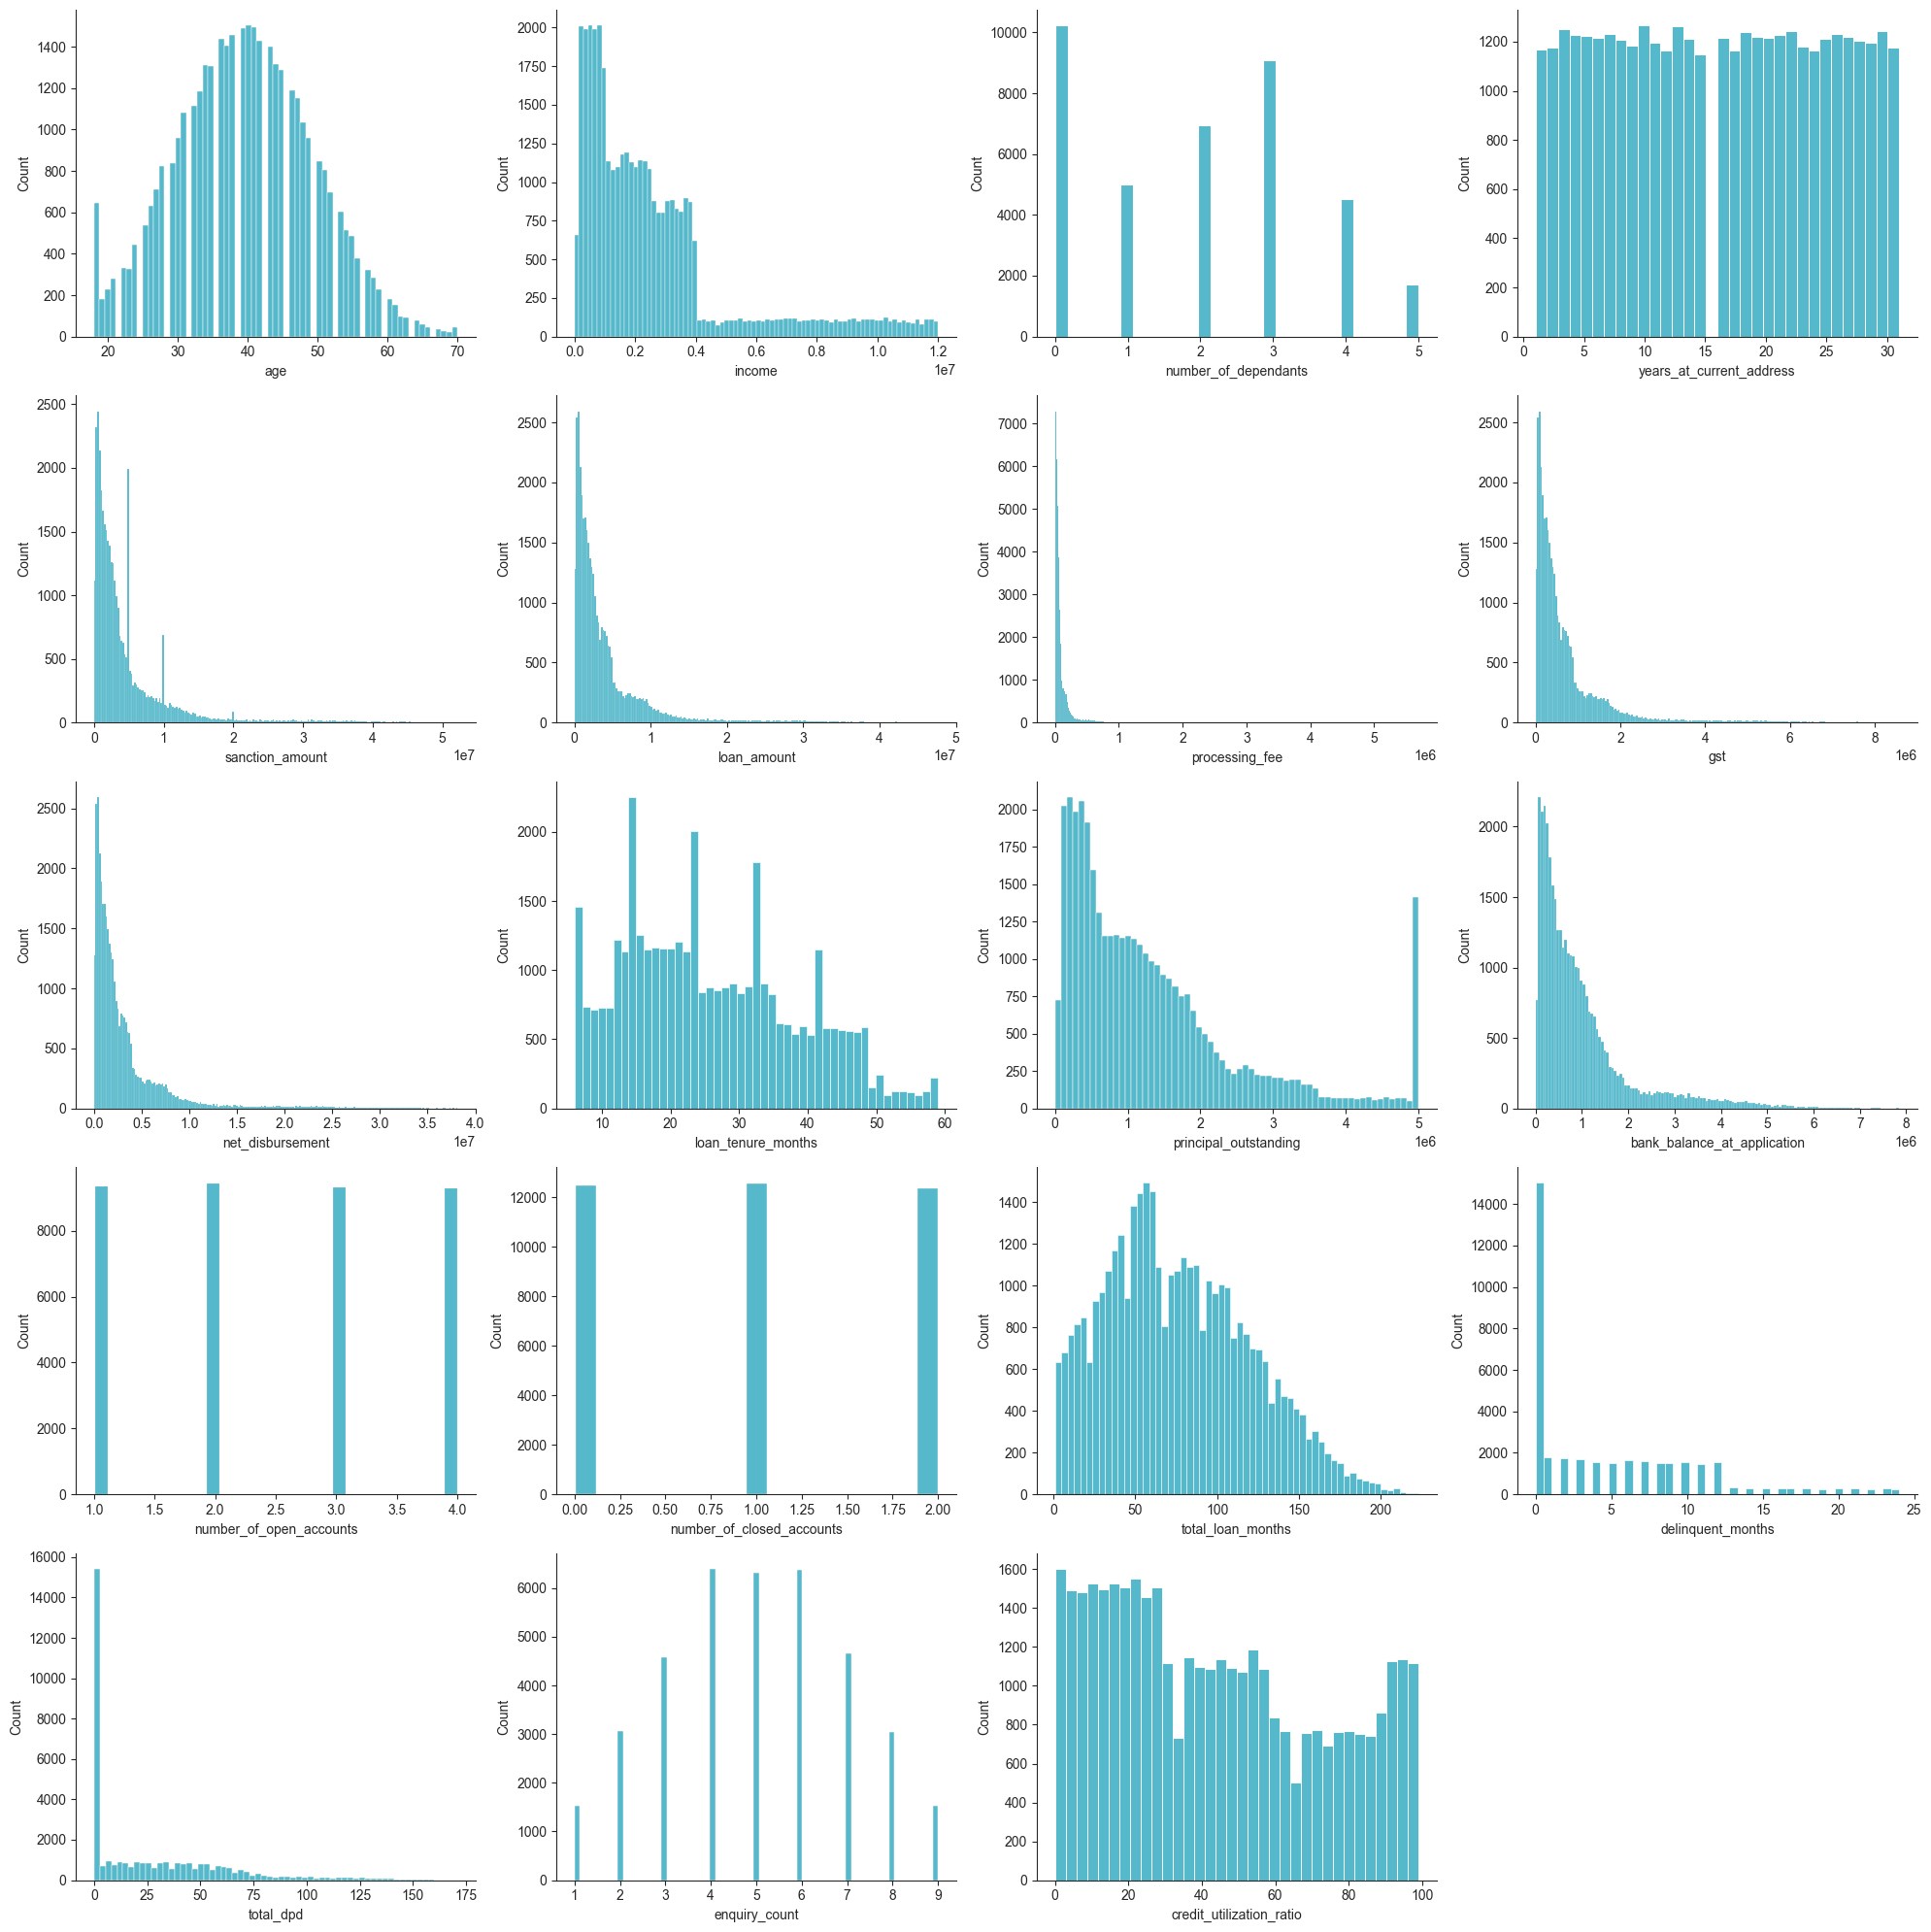

In [22]:
plt.figure(figsize=(20,20))

for i, col in enumerate(columns_numeric, start=1):
    plt.subplot(math.ceil(len(columns_numeric) / 4), 4, i)
    sns.histplot(x = df_train[col], color="#1EA0BA")


plt.tight_layout()
sns.despine()
plt.show()

Check the processing fee column since it is heavily skewed

In [23]:
df_train['processing_fee'].describe()

count    3.750000e+04
mean     8.072411e+04
std      1.208307e+05
min      0.000000e+00
25%      1.918000e+04
50%      4.470000e+04
75%      9.200000e+04
max      5.698030e+06
Name: processing_fee, dtype: float64

In [24]:
df_train[df_train.processing_fee == df_train.processing_fee.max()][["loan_amount","processing_fee"]]

,loan_amount,processing_fee
12294,4639000,5.698030e+06


In [25]:
5.698030e+06

5698030.0

In [26]:
# see where the processing fee is greater than loan amount
df_train[df_train.processing_fee > df_train.loan_amount][["loan_amount", "processing_fee"]]

,loan_amount,processing_fee
23981,2234000,2.669791e+06
9898,3626000,5.293544e+06
47089,1738000,1.858965e+06
33705,3812000,5.678021e+06
12294,4639000,5.698030e+06
28174,966000,1.214493e+06
29305,2616000,3.036378e+06


Business Rule Cleaning:

We remove records where processing fee > 3% of loan amount.

In [27]:
# Processing fee should not exceed 3% of loan amount
df_train[(df_train.processing_fee / df_train.loan_amount) > 0.03][["loan_amount", "processing_fee"]]

,loan_amount,processing_fee
23981,2234000,2.669791e+06
9898,3626000,5.293544e+06
47089,1738000,1.858965e+06
33705,3812000,5.678021e+06
12294,4639000,5.698030e+06
28174,966000,1.214493e+06
29305,2616000,3.036378e+06


In [28]:
df_train = df_train[(df_train.processing_fee / df_train.loan_amount) < 0.03].copy()
df_train[(df_train.processing_fee / df_train.loan_amount) > 0.03][["loan_amount", "processing_fee"]]

,loan_amount,processing_fee


In [29]:
#applying the smme logic in test set
df_test = df_test[(df_test.processing_fee / df_test.loan_amount) < 0.03].copy()
df_test.shape

(12498, 33)

<h3 style = "color:skyblue">Data inconsitency</h3>

Corrected typos such as "Personaal" → "Personal" in loan_purpose.

In [30]:
for col in columns_categorical:
    print(col, "->", df_train[col].unique())

gender -> ['F' 'M']
marital_status -> ['Single' 'Married']
employment_status -> ['Salaried' 'Self-Employed']
residence_type -> ['Owned' 'Mortgage' 'Rented']
state -> ['Gujarat' 'Delhi' 'Uttar Pradesh' 'Karnataka' 'Rajasthan' 'Telangana'
 'West Bengal' 'Maharashtra' 'Tamil Nadu']
zipcode -> [380001 110001 226001 560001 302001 500001 700001 411001 600001 400001]
loan_purpose -> ['Home' 'Auto' 'Personal' 'Education' 'Personaal']
loan_type -> ['Secured' 'Unsecured']
default -> [0 1]


In [31]:
# loan_purpose has some data inconsistency

df_train['loan_purpose'] = df_train['loan_purpose'].replace('Personaal', 'Personal')

df_test['loan_purpose'] = df_test['loan_purpose'].replace('Personaal', 'Personal')

df_train.loan_purpose.unique()

array(['Home', 'Auto', 'Personal', 'Education'], dtype=object)

<h3  style = "color: skyblue">Exploratory Data Analysis</h3>

In [32]:
columns_numeric

['age',
 'income',
 'number_of_dependants',
 'years_at_current_address',
 'sanction_amount',
 'loan_amount',
 'processing_fee',
 'gst',
 'net_disbursement',
 'loan_tenure_months',
 'principal_outstanding',
 'bank_balance_at_application',
 'number_of_open_accounts',
 'number_of_closed_accounts',
 'total_loan_months',
 'delinquent_months',
 'total_dpd',
 'enquiry_count',
 'credit_utilization_ratio']

KDE Plot by Age

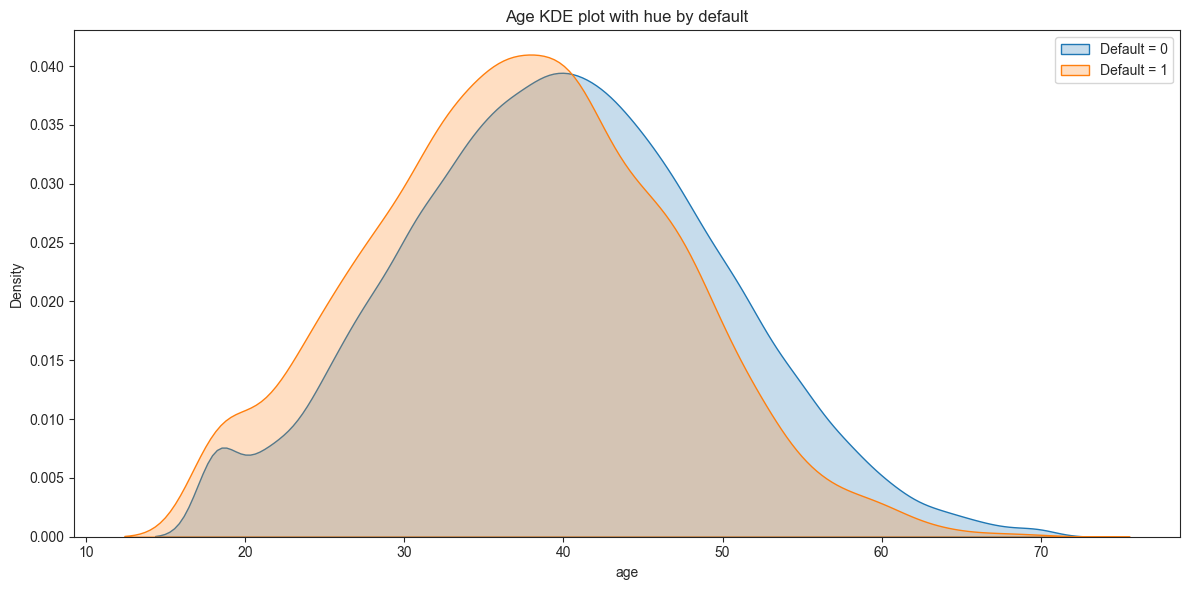

In [33]:
plt.figure(figsize=(12,6))
sns.kdeplot(df_train[df_train.default == 0]['age'], fill= True, label = "Default = 0")
sns.kdeplot(df_train[df_train.default == 1]['age'], fill= True, label = "Default = 1")
plt.title("Age KDE plot with hue by default") 
plt.legend()
plt.tight_layout()
plt.show()

Key Insight:

Orange graph is shifted to left of blue graph which indicates that people with young age are more likely to default

KDE Plots for All Numeric Columns

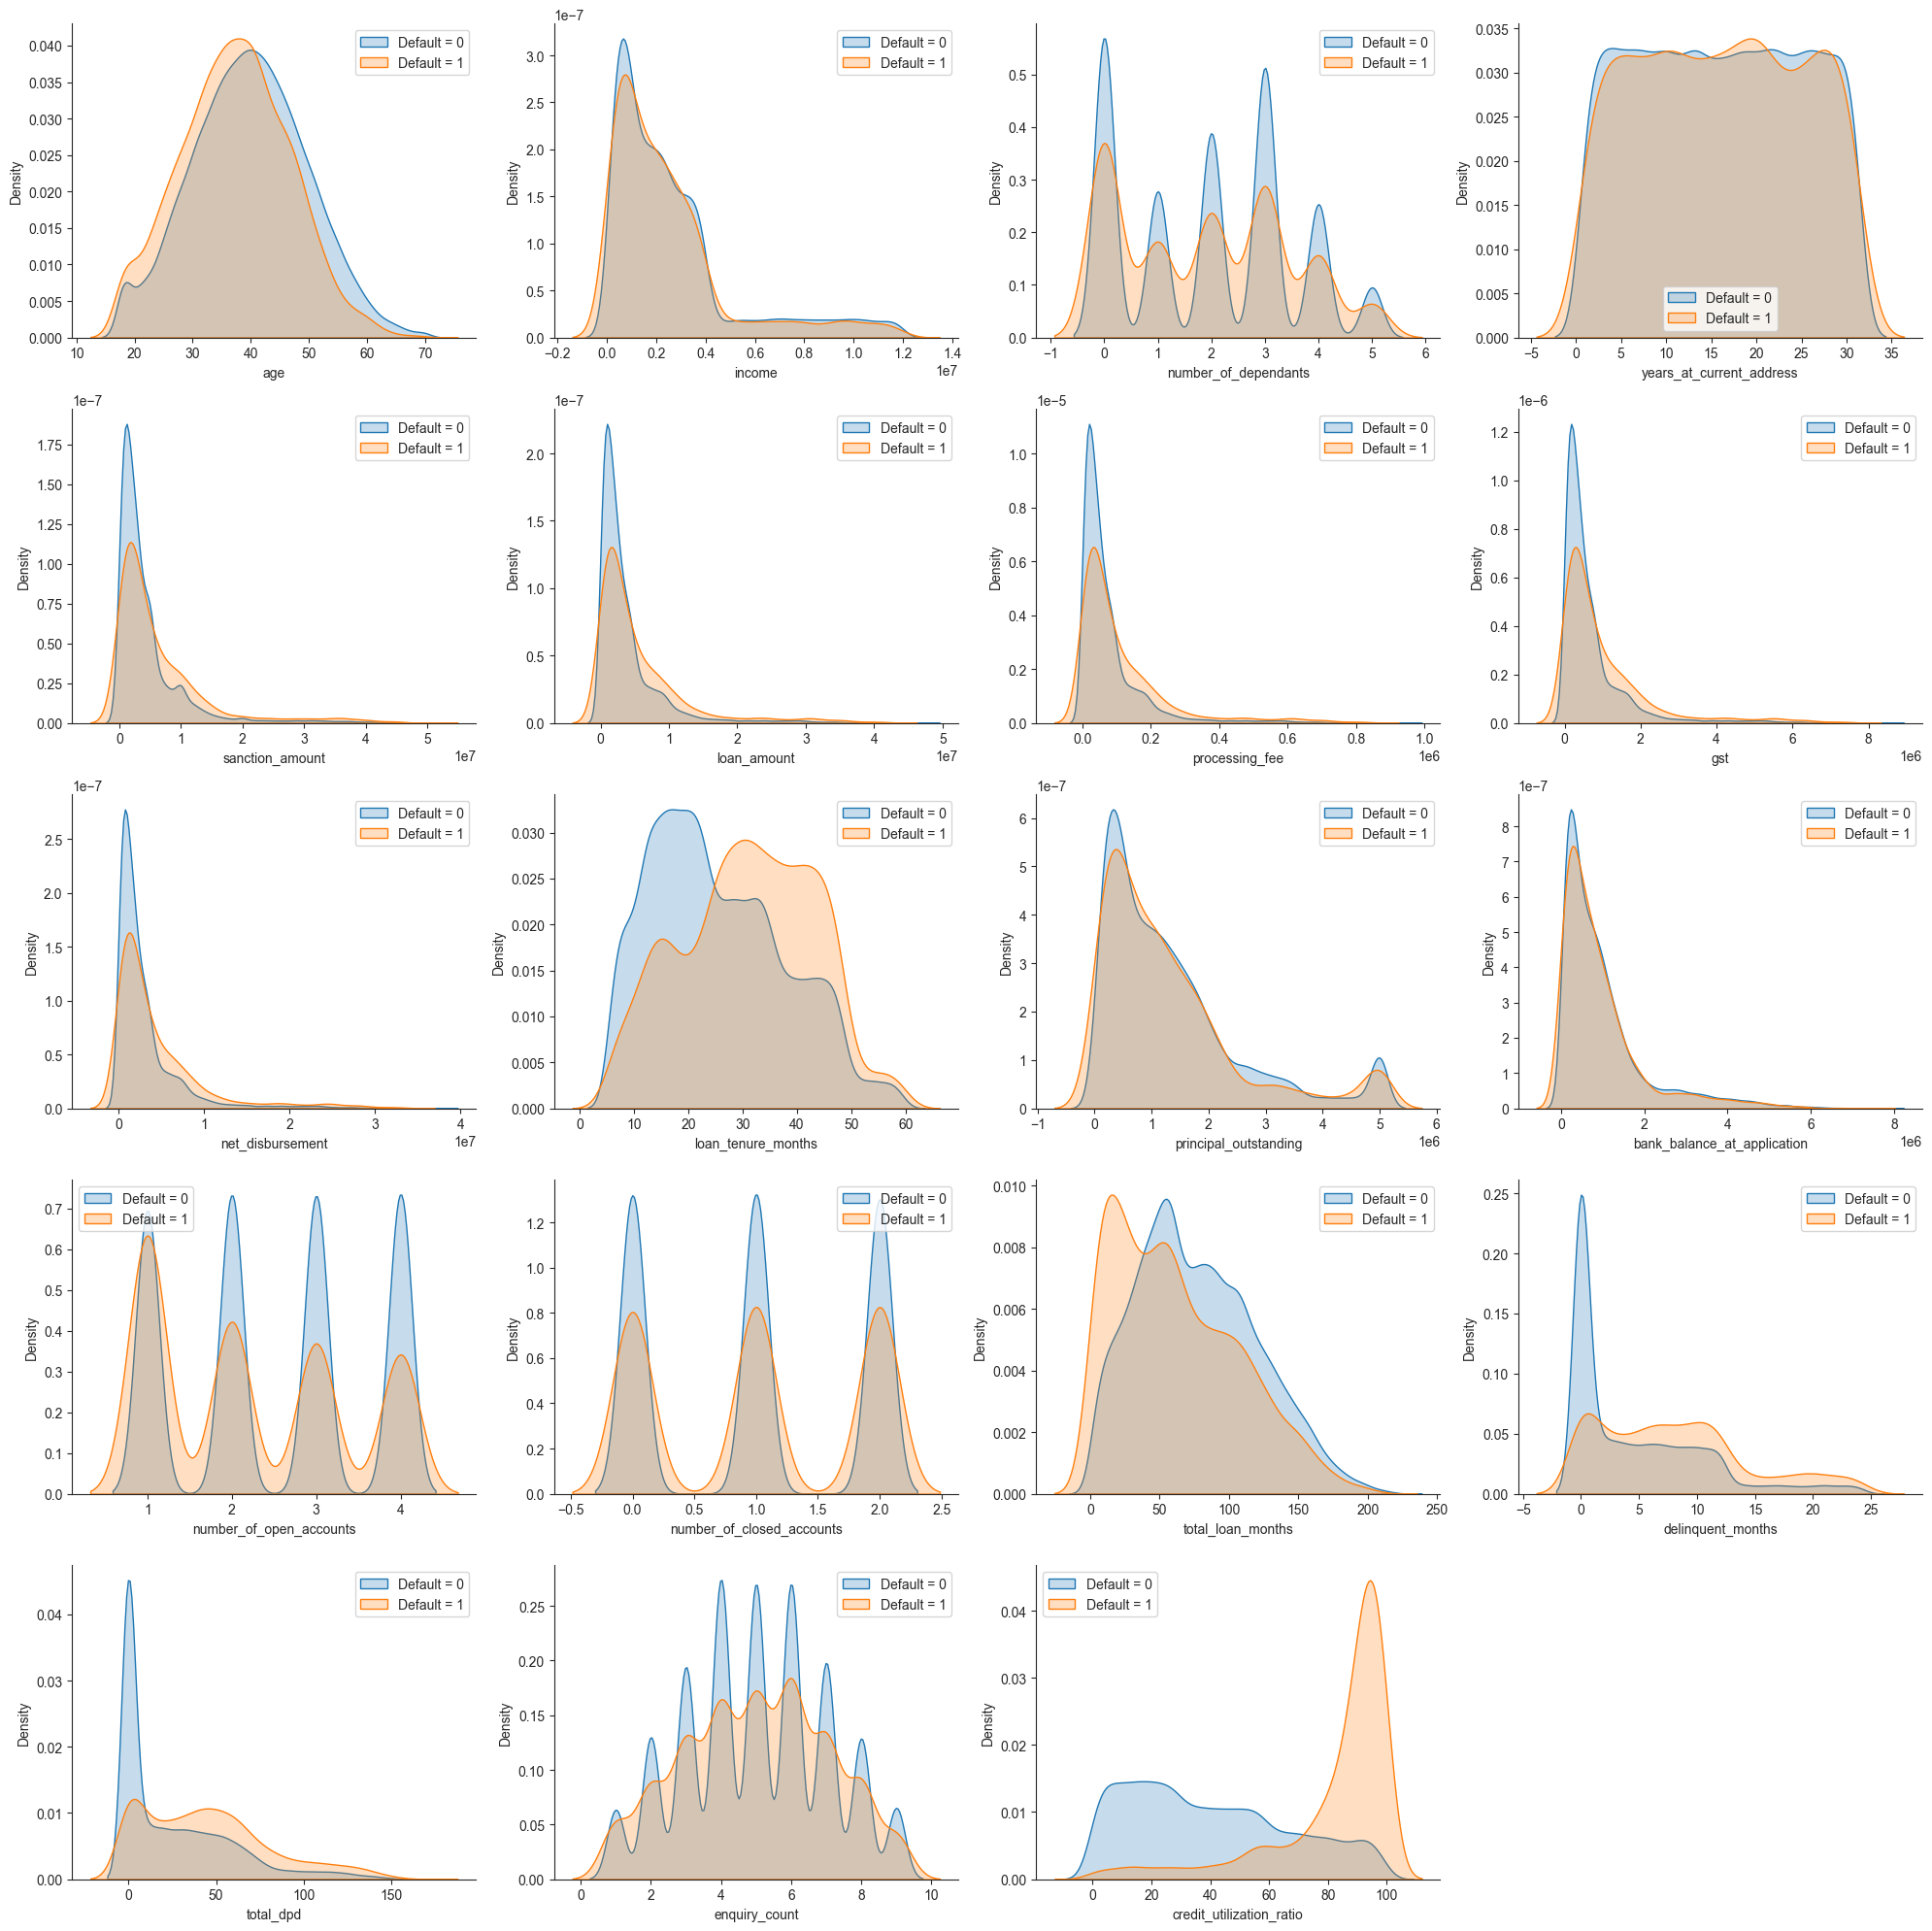

In [34]:
plt.figure(figsize=(20, 20))

for i, col in enumerate(columns_numeric, start=1):
    plt.subplot(math.ceil(len(columns_numeric) / 4), 4, i)  
    sns.kdeplot(df_train[df_train['default'] == 0][col], fill=True, label="Default = 0")
    sns.kdeplot(df_train[df_train['default'] == 1][col], fill=True, label="Default = 1")
    plt.legend()

plt.tight_layout()
sns.despine()
plt.show()

Key Insights:

1. In columns: loan_tenure_months, delinquent_months, total_dpd, credit_utilization, higher values indicate high likelyhood of becoming a default. Hence these 4 looks like strong predictors

2. In remaining columns the distributions do not give any obivious insights.

4. Why loan_amount and income did not give any signs of being strong predictors? May be when we combine these two and get loan to income ratio (LTI), that may have influence on the target variaables. We will explore more later.

<h3 style = "color: skyblue">Feature Engineering</h3>

In [35]:
df_train.columns

Index(['cust_id', 'age', 'gender', 'marital_status', 'employment_status',
       'income', 'number_of_dependants', 'residence_type',
       'years_at_current_address', 'city', 'state', 'zipcode', 'loan_id',
       'loan_purpose', 'loan_type', 'sanction_amount', 'loan_amount',
       'processing_fee', 'gst', 'net_disbursement', 'loan_tenure_months',
       'principal_outstanding', 'bank_balance_at_application',
       'disbursal_date', 'installment_start_dt', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio', 'default'],
      dtype='object')

1. Loan-to-Income Ratio

In [36]:
df_train["loan_to_income"] = (df_train["loan_amount"] / df_train["income"]).round(2)

#do same for the test dataset
df_test["loan_to_income"] = (df_test["loan_amount"] / df_test["income"]).round(2)


df_train["loan_to_income"].describe()

count    37487.000000
mean         1.554890
std          0.972907
min          0.300000
25%          0.770000
50%          1.160000
75%          2.450000
max          4.570000
Name: loan_to_income, dtype: float64

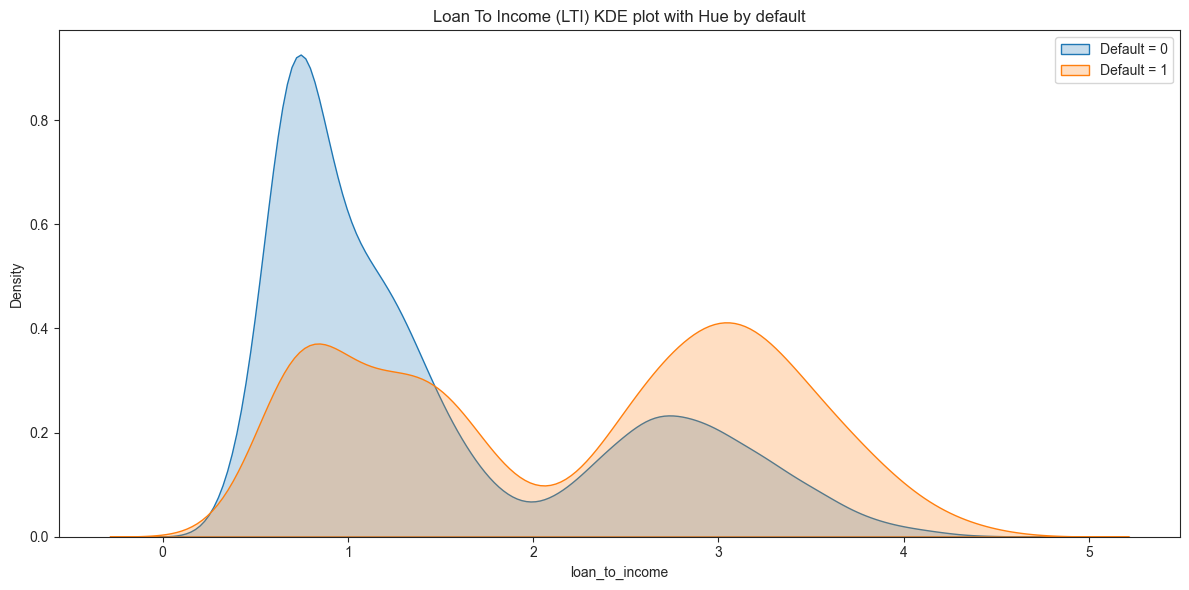

In [37]:
plt.figure(figsize=(12,6))
sns.kdeplot(df_train[df_train.default == 0]['loan_to_income'], fill= True, label = "Default = 0")
sns.kdeplot(df_train[df_train.default == 1]['loan_to_income'], fill= True, label = "Default = 1")
plt.title("Loan To Income (LTI) KDE plot with Hue by default") 
plt.legend()
plt.tight_layout()
plt.show()

Insight:
Loan-to-Income (LTI) ratio is more predictive than loan_amount or income alone.

2. Delinquency Ratio

In [38]:
df_train[["delinquent_months", "total_loan_months"]]

,delinquent_months,total_loan_months
27434,6,90
13400,4,119
883,14,83
7303,0,37
45124,6,62
...,...,...
11284,23,129
44732,0,80
38158,0,8
860,5,130


In [39]:
df_train['delinquency_ratio'] = (df_train['delinquent_months'] / df_train['total_loan_months'] * 100).round(2)

#do same for the test dataset
df_test['delinquency_ratio'] = (df_test['delinquent_months'] / df_test['total_loan_months'] * 100).round(2)

df_train[["delinquent_months", "total_loan_months", "delinquency_ratio"]].head()

,delinquent_months,total_loan_months,delinquency_ratio
27434,6,90,6.67
13400,4,119,3.36
883,14,83,16.87
7303,0,37,0.00
45124,6,62,9.68


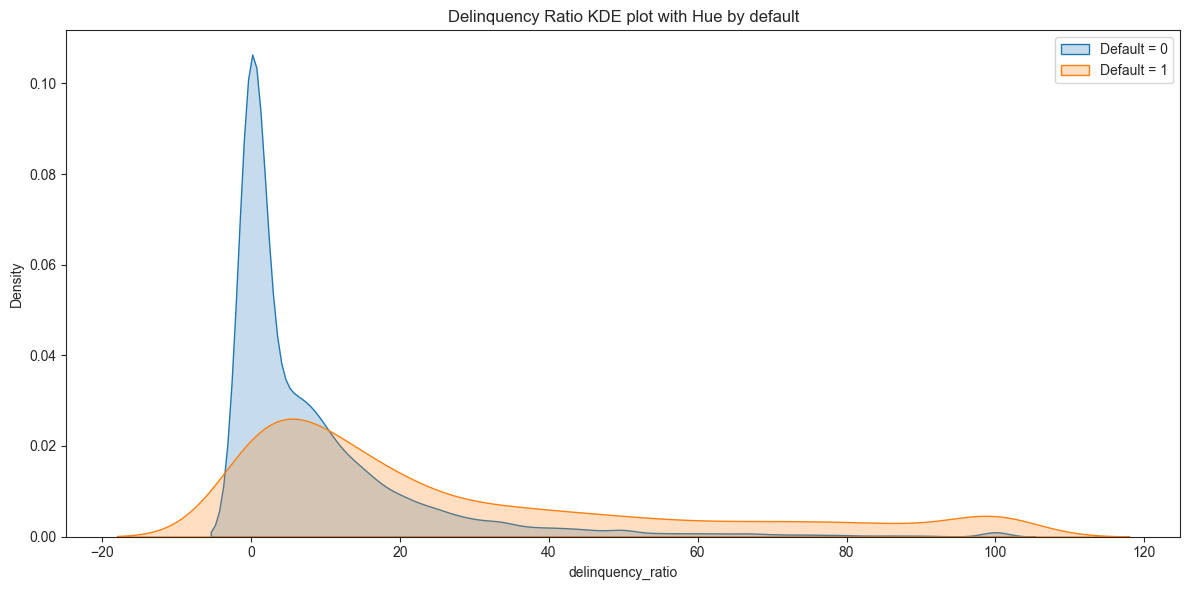

In [40]:
plt.figure(figsize=(12,6))
sns.kdeplot(df_train[df_train.default == 0]['delinquency_ratio'], fill= True, label = "Default = 0")
sns.kdeplot(df_train[df_train.default == 1]['delinquency_ratio'], fill= True, label = "Default = 1")
plt.title("Delinquency Ratio KDE plot with Hue by default") 
plt.legend()
plt.tight_layout()
plt.show()

Delinquent ratio is more predictive than delinquent_months or total_loan_months alone.

3. Average DPD per Delinquency

In [41]:
df_train['avg_dpd_per_delinquency'] = np.where(
    df_train['delinquent_months'] != 0,
    (df_train['total_dpd'] / df_train['delinquent_months']).round(2),
    0
)

# do same for the test dataset
df_test['avg_dpd_per_delinquency'] = np.where(
    df_test['delinquent_months'] != 0,
    (df_test['total_dpd'] / df_test['delinquent_months']).round(2),
    0
)


df_train['avg_dpd_per_delinquency'].describe()


count    37487.000000
mean         3.294614
std          2.903345
min          0.000000
25%          0.000000
50%          4.330000
75%          5.750000
max         10.000000
Name: avg_dpd_per_delinquency, dtype: float64

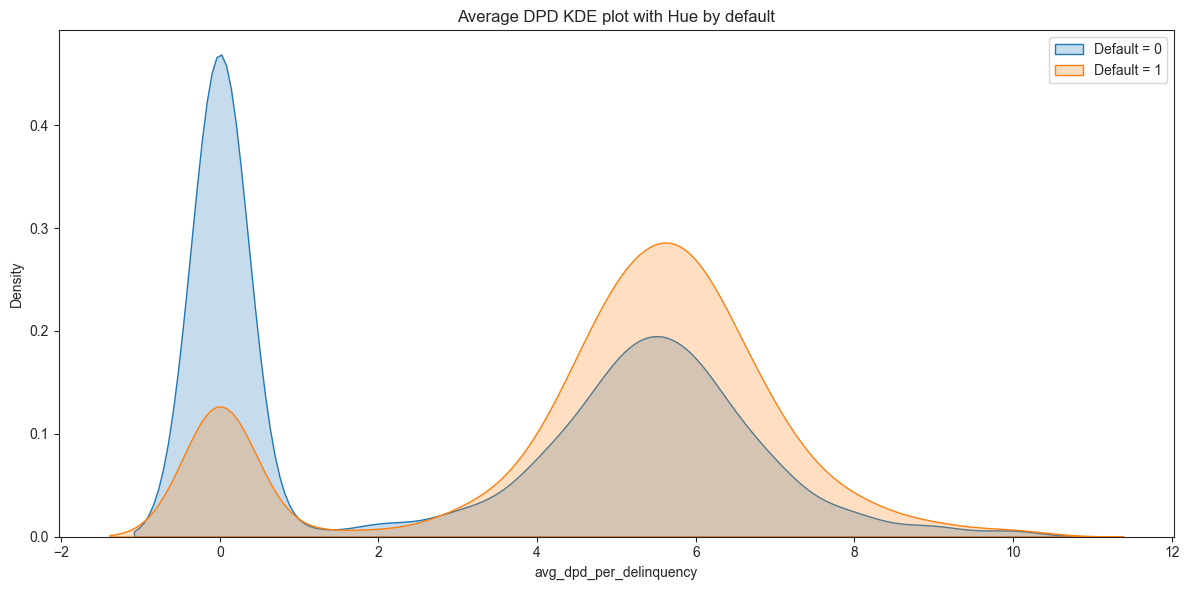

In [42]:
plt.figure(figsize=(12,6))
sns.kdeplot(df_train[df_train.default == 0]['avg_dpd_per_delinquency'], fill= True, label = "Default = 0")
sns.kdeplot(df_train[df_train.default == 1]['avg_dpd_per_delinquency'], fill= True, label = "Default = 1")
plt.title("Average DPD KDE plot with Hue by default") 
plt.legend()
plt.tight_layout()
plt.show()


Average DPD per delinquent months is more predictive than total_dpd or total_delinquent_months alone

<h3 style = "color:skyblue">Feature Selection I</h3> 

In [43]:
# based on the technical knowledge we drop those columns
df_train = df_train.drop(columns=['cust_id', 'loan_id'])
df_test = df_test.drop(columns=['cust_id', 'loan_id'])

In [44]:
#based on the business knowledge we drop irrelevant or leaky features

df_train = df_train.drop(columns=['disbursal_date', 'installment_start_dt',  'loan_amount', 'income', 'total_loan_months', 'delinquent_months', 'total_dpd'])

df_test = df_test.drop(columns=['disbursal_date', 'installment_start_dt',  'loan_amount', 'income', 'total_loan_months', 'delinquent_months', 'total_dpd'])

df_train.columns

Index(['age', 'gender', 'marital_status', 'employment_status',
       'number_of_dependants', 'residence_type', 'years_at_current_address',
       'city', 'state', 'zipcode', 'loan_purpose', 'loan_type',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'default', 'loan_to_income',
       'delinquency_ratio', 'avg_dpd_per_delinquency'],
      dtype='object')

<h3 style = "color:skyblue">Feature Scaling</h3>

In [45]:
X_train.select_dtypes('number').drop(columns=['zipcode']).columns

Index(['age', 'income', 'number_of_dependants', 'years_at_current_address',
       'sanction_amount', 'loan_amount', 'processing_fee', 'gst',
       'net_disbursement', 'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'total_loan_months', 'delinquent_months',
       'total_dpd', 'enquiry_count', 'credit_utilization_ratio'],
      dtype='object')

In [46]:
X_train = df_train.drop(columns=['default'])
y_train = df_train['default']


cols_to_scale = X_train.select_dtypes('number').drop(columns=['zipcode']).columns

scaler = MinMaxScaler()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_train.describe()

,age,number_of_dependants,years_at_current_address,zipcode,sanction_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
count,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000,37487.000000
mean,0.414681,0.388476,0.499787,418763.450983,0.088989,0.083030,0.083030,0.083030,0.375431,0.261931,0.123683,0.498795,0.498386,0.500410,0.437656,0.293885,0.103945,0.329461
std,0.189510,0.307163,0.297939,168837.508873,0.120709,0.113437,0.113437,0.113437,0.234410,0.244515,0.133507,0.372407,0.407528,0.252997,0.296517,0.227847,0.172686,0.290335
min,0.000000,0.000000,0.000000,110001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.288462,0.000000,0.233333,302001.000000,0.020440,0.019100,0.019100,0.019100,0.188679,0.078179,0.034088,0.000000,0.000000,0.375000,0.181818,0.110070,0.000000,0.000000
50%,0.423077,0.400000,0.500000,400001.000000,0.049536,0.045887,0.045887,0.045887,0.339623,0.194385,0.082720,0.333333,0.500000,0.500000,0.393939,0.201405,0.038000,0.433000
75%,0.538462,0.600000,0.766667,560001.000000,0.097660,0.095512,0.095512,0.095512,0.547170,0.353152,0.155525,0.666667,1.000000,0.625000,0.676768,0.503513,0.131100,0.575000
max,1.000000,1.000000,1.000000,700001.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
#same for the test dataset
X_test = df_test.drop(columns=['default'])
y_test = df_test['default']


X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_test.describe()

,age,number_of_dependants,years_at_current_address,zipcode,sanction_amount,processing_fee,gst,net_disbursement,loan_tenure_months,principal_outstanding,bank_balance_at_application,number_of_open_accounts,number_of_closed_accounts,enquiry_count,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
count,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000,12498.000000
mean,0.413678,0.386174,0.503088,420098.055529,0.088840,0.082764,0.082764,0.082764,0.378690,0.263201,0.124546,0.503681,0.506961,0.503471,0.439030,0.294318,0.104142,0.330726
std,0.189011,0.306940,0.296372,169419.472823,0.119051,0.111372,0.111372,0.111372,0.235128,0.245299,0.134018,0.374460,0.405600,0.255602,0.296583,0.226731,0.173989,0.290738
min,0.000000,0.000000,0.000000,110001.000000,0.000019,0.000126,0.000126,0.000126,0.000000,-0.000163,0.000216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.288462,0.000000,0.233333,302001.000000,0.021208,0.019725,0.019725,0.019725,0.188679,0.078853,0.034518,0.000000,0.000000,0.375000,0.181818,0.110070,0.000000,0.000000
50%,0.423077,0.400000,0.500000,411001.000000,0.049871,0.046244,0.046244,0.046244,0.358491,0.195309,0.083575,0.666667,0.500000,0.500000,0.393939,0.203747,0.037700,0.433000
75%,0.538462,0.600000,0.766667,560001.000000,0.099138,0.096693,0.096693,0.096693,0.547170,0.354632,0.156611,1.000000,1.000000,0.750000,0.676768,0.503513,0.129000,0.574750
max,1.000000,1.000000,1.000000,700001.000000,0.951002,1.003192,1.003192,1.003192,1.000000,1.000000,0.879450,1.000000,1.000000,1.000000,1.000000,1.004684,1.000000,1.000000


<h3 style = "color:skyblue">Multicollinearity Check (VIF)</h3>

In [48]:
## Fuction that calculate VIF

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return vif_df

calculate_vif(X_train[cols_to_scale])

,Column,VIF
0,age,5.583328
1,number_of_dependants,2.722931
2,years_at_current_address,3.361640
3,sanction_amount,102.151612
4,processing_fee,inf
5,gst,inf
6,net_disbursement,inf
7,loan_tenure_months,6.132184
8,principal_outstanding,16.269126
9,bank_balance_at_application,9.266642


Drop Highly Correlated Features

In [49]:
feature_to_drop_vif = ['sanction_amount', 'processing_fee', 'gst', 'net_disbursement', 'principal_outstanding']

X_train = X_train.drop(feature_to_drop_vif, axis='columns')

X_test = X_test.drop(feature_to_drop_vif, axis= "columns")


In [50]:
numerical_columns_vif = X_train.select_dtypes('number').columns
numerical_columns_vif

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [51]:
vif_df = calculate_vif(X_train[numerical_columns_vif])
vif_df

,Column,VIF
0,age,5.547281
1,number_of_dependants,2.733648
2,years_at_current_address,3.449703
3,zipcode,5.596398
4,loan_tenure_months,5.992031
5,bank_balance_at_application,1.806712
6,number_of_open_accounts,4.325328
7,number_of_closed_accounts,2.365621
8,enquiry_count,6.422745
9,credit_utilization_ratio,2.942060


In [52]:
selected_numeric_feature_vif = vif_df.Column.values
selected_numeric_feature_vif

array(['age', 'number_of_dependants', 'years_at_current_address',
       'zipcode', 'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts',
       'enquiry_count', 'credit_utilization_ratio', 'loan_to_income',
       'delinquency_ratio', 'avg_dpd_per_delinquency'], dtype=object)

Correlation Heatmap

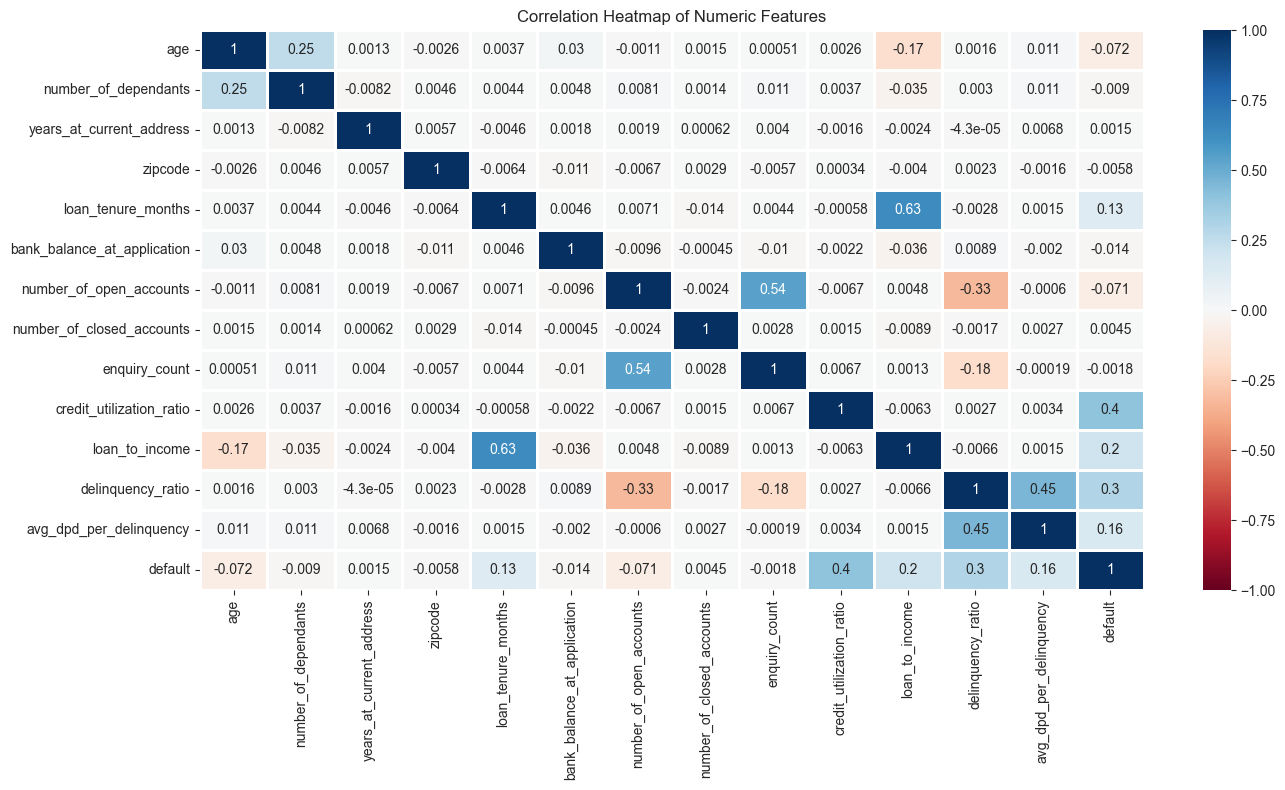

In [53]:
plt.figure(figsize=(14,8))

cols_for_corr = selected_numeric_feature_vif.tolist() + ['default']

corr = df_train[cols_for_corr].corr()
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap="RdBu", linewidths=1)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

In [54]:
selected_numeric_feature_vif

array(['age', 'number_of_dependants', 'years_at_current_address',
       'zipcode', 'loan_tenure_months', 'bank_balance_at_application',
       'number_of_open_accounts', 'number_of_closed_accounts',
       'enquiry_count', 'credit_utilization_ratio', 'loan_to_income',
       'delinquency_ratio', 'avg_dpd_per_delinquency'], dtype=object)

<h3 style = "color:skyblue">Feature Selection II : Categorical Features<h3>

In [55]:
columns_categorical

['gender',
 'marital_status',
 'employment_status',
 'residence_type',
 'state',
 'zipcode',
 'loan_purpose',
 'loan_type',
 'default']

Calculate WOE and IV

In [56]:
def calculate_woe_iv(df, feature, target):
    grouped = df.groupby(feature)[target].agg(['count', 'sum']).rename(columns = {'count':'total', 'sum':'bad'})
    
    grouped['good'] = grouped['total'] - grouped['bad']

    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()
    
    grouped['good_pct'] = grouped['good'] / total_good
    grouped['bad_pct'] = grouped['bad'] / total_bad
    
    
    grouped['woe'] = np.log(grouped['good_pct']/ grouped['bad_pct'])
    grouped['iv'] = (grouped['good_pct'] -grouped['bad_pct']) * grouped['woe']
    
    grouped['woe'] = grouped['woe'].replace([np.inf, -np.inf], 0)
    grouped['iv'] = grouped['iv'].replace([np.inf, -np.inf], 0)

    total_iv = grouped['iv'].sum()
    
    return grouped, total_iv

# test the function
grouped, total_iv = calculate_woe_iv(pd.concat([X_train, y_train], axis = 1), 'loan_purpose', 'default')

grouped

,total,bad,good,good_pct,bad_pct,woe,iv
loan_purpose,,,,,,,
Auto,7437,314,7123,0.207680,0.098463,0.746312,0.081509
Education,5626,546,5080,0.148114,0.171214,-0.144932,0.003348
Home,11271,1744,9527,0.277771,0.546880,-0.677431,0.182303
Personal,13153,585,12568,0.366435,0.183443,0.691918,0.126616


In [57]:
iv_values = {}

for feature in X_train.columns:
    if X_train[feature].dtype == 'object':
        _, iv = calculate_woe_iv(pd.concat([X_train, y_train], axis = 1), feature, 'default')
        
    else:
        X_binned = pd.cut(X_train[feature], bins=10, labels= False)
        _, iv = calculate_woe_iv(pd.concat([X_binned, y_train], axis = 1), feature, 'default')
    
    iv_values[feature] = iv.round(3)


iv_values

{'age': np.float64(0.076),
 'gender': np.float64(0.0),
 'marital_status': np.float64(0.002),
 'employment_status': np.float64(0.002),
 'number_of_dependants': np.float64(0.004),
 'residence_type': np.float64(0.259),
 'years_at_current_address': np.float64(0.001),
 'city': np.float64(0.001),
 'state': np.float64(0.001),
 'zipcode': np.float64(0.001),
 'loan_purpose': np.float64(0.394),
 'loan_type': np.float64(0.173),
 'loan_tenure_months': np.float64(0.235),
 'bank_balance_at_application': np.float64(0.004),
 'number_of_open_accounts': np.float64(0.073),
 'number_of_closed_accounts': np.float64(0.0),
 'enquiry_count': np.float64(0.005),
 'credit_utilization_ratio': np.float64(2.423),
 'loan_to_income': np.float64(0.492),
 'delinquency_ratio': np.float64(0.678),
 'avg_dpd_per_delinquency': np.float64(0.421)}

In [58]:
iv_df = pd.DataFrame(list(iv_values.items()), columns = ['Feature', 'IV'])
iv_df = iv_df.sort_values(by="IV", ascending= False)
iv_df

,Feature,IV
17,credit_utilization_ratio,2.423
19,delinquency_ratio,0.678
18,loan_to_income,0.492
20,avg_dpd_per_delinquency,0.421
10,loan_purpose,0.394
5,residence_type,0.259
12,loan_tenure_months,0.235
11,loan_type,0.173
0,age,0.076
14,number_of_open_accounts,0.073


In [59]:
# select features that has IV > 0.02
selected_features_iv = [feature for feature, iv in iv_values.items() if iv > 0.02]
selected_features_iv

['age',
 'residence_type',
 'loan_purpose',
 'loan_type',
 'loan_tenure_months',
 'number_of_open_accounts',
 'credit_utilization_ratio',
 'loan_to_income',
 'delinquency_ratio',
 'avg_dpd_per_delinquency']

In [60]:
## Selected features due to iv 
X_train = X_train[selected_features_iv].reset_index(drop='index')
X_test = X_test[selected_features_iv].reset_index(drop='index')

In [61]:
X_train.head()

,age,residence_type,loan_purpose,loan_type,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency
0,0.519231,Owned,Home,Secured,0.339623,1.000000,0.595960,0.608899,0.0667,0.550
1,0.211538,Owned,Auto,Secured,0.509434,0.666667,0.929293,0.182670,0.0336,0.425
2,0.615385,Mortgage,Personal,Unsecured,0.245283,0.333333,0.838384,0.084309,0.1687,0.557
3,0.480769,Owned,Auto,Secured,0.283019,0.000000,0.343434,0.187354,0.0000,0.000
4,0.250000,Owned,Education,Secured,0.735849,0.333333,0.191919,0.360656,0.0968,0.467


<h3 style = "color:skyblue">Feature Encoding</h3>

In [62]:
X_train_encoded = pd.get_dummies(X_train, drop_first= True, dtype='int')
X_test_encoded = pd.get_dummies(X_test, drop_first= True, dtype='int')

X_train_encoded.head()



,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_Owned,residence_type_Rented,loan_purpose_Education,loan_purpose_Home,loan_purpose_Personal,loan_type_Unsecured
0,0.519231,0.339623,1.000000,0.595960,0.608899,0.0667,0.550,1,0,0,1,0,0
1,0.211538,0.509434,0.666667,0.929293,0.182670,0.0336,0.425,1,0,0,0,0,0
2,0.615385,0.245283,0.333333,0.838384,0.084309,0.1687,0.557,0,0,0,0,1,1
3,0.480769,0.283019,0.000000,0.343434,0.187354,0.0000,0.000,1,0,0,0,0,0
4,0.250000,0.735849,0.333333,0.191919,0.360656,0.0968,0.467,1,0,1,0,0,0


<h3 style = "color:skyblue">Model Training</h3>

Attempt 1

1. Logistic Regression, RandomForest & XGB
1. No handling of class imbalance

In [63]:
#Logistic Regresssion
model = LogisticRegression(max_iter=3000)
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11390
           1       0.84      0.69      0.76      1108

    accuracy                           0.96     12498
   macro avg       0.90      0.84      0.87     12498
weighted avg       0.96      0.96      0.96     12498



In [64]:
#Random Forest
model = RandomForestClassifier()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
report = classification_report(y_pred, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11574
           1       0.70      0.84      0.77       924

    accuracy                           0.96     12498
   macro avg       0.84      0.91      0.87     12498
weighted avg       0.97      0.96      0.96     12498



In [65]:
#Xgboost
model = XGBClassifier()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11390
           1       0.82      0.74      0.78      1108

    accuracy                           0.96     12498
   macro avg       0.90      0.86      0.88     12498
weighted avg       0.96      0.96      0.96     12498



Since there is not much difference between XGB, RandomForest compared to Logistic, we will choose LogisticRegression as a candidate for our RandomizedSearchCV since it has a better interpretation.

<h3 style = "color:skyblue">RandomizedSearch CV: Logistic Regression</h3>

In [66]:
param_dist = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 20, 30, 50, 100],  
    'solver': ['lgfgs', 'saga', 'liblinear', 'newton-cg'] 
}

#model
log_reg = LogisticRegression(max_iter=10000)

#setup randomizedsearchcv
random_search = RandomizedSearchCV(
    estimator= log_reg,
    param_distributions= param_dist,
    n_iter= 50,
    scoring= 'f1',
    cv = 5,
    refit=True,
    verbose= 2,
    random_state= 42,
    n_jobs= -1,

)

#fit the training data
random_search.fit(X_train_encoded, y_train)

#print the best parameters and best scores
print(f"Best parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

#best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report: ")
print(classification_report(y_test, y_pred))



Fitting 5 folds for each of 44 candidates, totalling 220 fits
Best parameters: {'solver': 'saga', 'C': 30}
Best Score: 0.7626880376013141
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11390
           1       0.83      0.71      0.77      1108

    accuracy                           0.96     12498
   macro avg       0.90      0.85      0.87     12498
weighted avg       0.96      0.96      0.96     12498



<h3 style = "color:skyblue">RandomizedSearch CV: XGBoost</h3>

In [67]:
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 2, 3, 5, 7, 10],
    'reg_alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],  # L1 regularization term
    'reg_lambda': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]  # L2 regularization term
}

#model
xgb = XGBClassifier()

#setup randomizedsearchcv
random_search = RandomizedSearchCV(
    estimator= xgb,
    param_distributions= param_dist,
    n_iter= 100,
    scoring= 'f1',
    cv = 5,
    refit=True,
    verbose= 2,
    random_state= 42,
    n_jobs= -1,

)

#fit the training data
random_search.fit(X_train_encoded, y_train)

#print the best parameters and best scores
print(f"Best parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

#best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_encoded)
print("Classification Report: ")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 1.0, 'reg_alpha': 5.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best Score: 0.791045508404032
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11390
           1       0.78      0.82      0.80      1108

    accuracy                           0.96     12498
   macro avg       0.88      0.90      0.89     12498
weighted avg       0.96      0.96      0.96     12498



Attempt 2

1. Logistic Regression & XGB
1. Handle Class Imbalance Using Under Sampling

Class imbalance

In [68]:
rus = RandomUnderSampler(random_state= 42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_encoded, y_train)

y_train_rus.value_counts()

default
0    3189
1    3189
Name: count, dtype: int64

In [69]:
#Logistic Regresssion
model = LogisticRegression(max_iter=3000)
model.fit(X_train_rus, y_train_rus)

y_pred = model.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     11390
           1       0.53      0.95      0.68      1108

    accuracy                           0.92     12498
   macro avg       0.76      0.93      0.82     12498
weighted avg       0.95      0.92      0.93     12498



In [70]:
#Xgboost
model = XGBClassifier()
model.fit(X_train_rus, y_train_rus)

y_pred = model.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11390
           1       0.57      0.94      0.71      1108

    accuracy                           0.93     12498
   macro avg       0.78      0.94      0.84     12498
weighted avg       0.96      0.93      0.94     12498



Attempt 3

1. Logistic Regression
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [71]:
smt = SMOTETomek(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_encoded, y_train)

y_train_smt.value_counts()

default
0    34226
1    34226
Name: count, dtype: int64

In [72]:
#Logistic Regresssion
model = LogisticRegression(max_iter=3000)
model.fit(X_train_smt, y_train_smt)

y_pred = model.predict(X_test_encoded)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11390
           1       0.57      0.94      0.71      1108

    accuracy                           0.93     12498
   macro avg       0.78      0.94      0.83     12498
weighted avg       0.96      0.93      0.94     12498



In [73]:
def objective(trial):
    
    #create a parameter space
    param = {
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),  # Logarithmically spaced values
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'newton-cg']),  # Solvers
        'tol': trial.suggest_float('tol', 1e-6, 1e-1, log=True),  # Logarithmically spaced values for tolerance
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])  # Class weights
    }

    #model
    model = LogisticRegression(**param, max_iter=10000, random_state= 42)


    # Calculate the cross-validated f1_score
    f1_scorer = make_scorer(f1_score, average = "macro")
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=  5, scoring= f1_scorer, n_jobs= -1)

    return np.mean(scores) 


#create a study object and optimize the objective function
study_logistic = optuna.create_study(direction="maximize", sampler= optuna.samplers.TPESampler())
study_logistic.optimize(objective, n_trials=50)

[I 2025-11-01 10:05:44,554] A new study created in memory with name: no-name-18a470df-481b-4f92-9d1e-f01e73b13352
[I 2025-11-01 10:05:44,782] Trial 0 finished with value: 0.9223371624541482 and parameters: {'C': 0.03183684240558226, 'solver': 'lbfgs', 'tol': 0.006042791903134471, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9223371624541482.
[I 2025-11-01 10:05:45,041] Trial 1 finished with value: 0.9258697546046115 and parameters: {'C': 0.0055528716827553766, 'solver': 'saga', 'tol': 0.005289060656605844, 'class_weight': None}. Best is trial 1 with value: 0.9258697546046115.
[I 2025-11-01 10:05:45,419] Trial 2 finished with value: 0.9449400403360949 and parameters: {'C': 92.18374803157954, 'solver': 'liblinear', 'tol': 0.000348352228832929, 'class_weight': None}. Best is trial 2 with value: 0.9449400403360949.
[I 2025-11-01 10:05:45,716] Trial 3 finished with value: 0.9448962332167092 and parameters: {'C': 98.20467365646805, 'solver': 'lbfgs', 'tol': 4.823048077014093e-0

In [74]:
print(f"Best F1 score: {study_logistic.best_value}")

print(f"Best hyperparameters: {study_logistic.best_params}")

best_model_logistic = LogisticRegression(**study_logistic.best_params, random_state= 42)
best_model_logistic.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_logistic.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)


Best F1 score: 0.9449546287719975
Best hyperparameters: {'C': 126.93466577744579, 'solver': 'liblinear', 'tol': 8.196123905815782e-06, 'class_weight': None}
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11390
           1       0.57      0.94      0.71      1108

    accuracy                           0.93     12498
   macro avg       0.78      0.93      0.83     12498
weighted avg       0.96      0.93      0.94     12498



Attempt 4

1. XGBoost
1. Handle Class Imbalance Using SMOTE Tomek
1. Parameter tunning using optuna

In [75]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'verbosity': 0,
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10)
    }

    #model
    model = XGBClassifier(**param)

    
    # Calculate the cross-validated f1_score
    f1_scorer = make_scorer(f1_score, average = "macro")
    scores = cross_val_score(model, X_train_smt, y_train_smt, cv=  5, scoring= f1_scorer, n_jobs= -1)

    return np.mean(scores) 


#create a study object and optimize the objective function
study_xgb = optuna.create_study(direction="maximize", sampler= optuna.samplers.TPESampler())
study_xgb.optimize(objective, n_trials=50)
    
    

[I 2025-11-01 10:06:05,816] A new study created in memory with name: no-name-666f9de9-055b-4311-8488-fd4983c30d61
[I 2025-11-01 10:06:07,376] Trial 0 finished with value: 0.9714089646601158 and parameters: {'lambda': 0.5706386869689353, 'alpha': 0.1943281516439779, 'subsample': 0.6480885555697065, 'colsample_bytree': 0.6680491937998068, 'max_depth': 8, 'eta': 0.14090815354887035, 'gamma': 2.2279767585159993, 'scale_pos_weight': 2.83699928629258, 'min_child_weight': 9, 'max_delta_step': 9}. Best is trial 0 with value: 0.9714089646601158.
[I 2025-11-01 10:06:08,558] Trial 1 finished with value: 0.962476472756103 and parameters: {'lambda': 0.012730769115997957, 'alpha': 4.086751555976592, 'subsample': 0.4462872045912271, 'colsample_bytree': 0.4555166483154997, 'max_depth': 5, 'eta': 0.2092889707231174, 'gamma': 8.492440958095656, 'scale_pos_weight': 2.0132493602618506, 'min_child_weight': 1, 'max_delta_step': 1}. Best is trial 0 with value: 0.9714089646601158.
[I 2025-11-01 10:06:09,786] 

In [76]:
print(f"Best F1 score: {study_xgb.best_value}")

print(f"Best hyperparameters: {study_xgb.best_params}")

best_model_xgb = XGBClassifier(**study_xgb.best_params)
best_model_xgb.fit(X_train_smt, y_train_smt)

# Evaluate on the test set
y_pred = best_model_xgb.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print("Report:\n")
print(report)

Best F1 score: 0.9758297170254941
Best hyperparameters: {'lambda': 0.8200271285439031, 'alpha': 0.19779510767185313, 'subsample': 0.7283102012186402, 'colsample_bytree': 0.7240454479423559, 'max_depth': 9, 'eta': 0.21454608668019856, 'gamma': 0.015211823165226623, 'scale_pos_weight': 2.5429101344790315, 'min_child_weight': 8, 'max_delta_step': 5}
Report:

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     11390
           1       0.70      0.87      0.78      1108

    accuracy                           0.96     12498
   macro avg       0.84      0.92      0.88     12498
weighted avg       0.96      0.96      0.96     12498



In [77]:
## we chose logistic regression
y_pred = best_model_logistic.predict(X_test_encoded)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11390
           1       0.57      0.94      0.71      1108

    accuracy                           0.93     12498
   macro avg       0.78      0.93      0.83     12498
weighted avg       0.96      0.93      0.94     12498



#### Model Evaluation : ROC/AUC

In [78]:
y_scores = best_model_logistic.predict_proba(X_test_encoded)[:,1]
y_scores

fpr, tpr, threshold = roc_curve(y_test, y_scores)

fpr[:10], tpr[:10], threshold[:10]

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.77963126e-05,
        8.77963126e-05, 1.75592625e-04, 1.75592625e-04, 2.63388938e-04,
        2.63388938e-04, 3.51185250e-04]),
 array([0.        , 0.00090253, 0.20938628, 0.20938628, 0.21841155,
        0.21841155, 0.26444043, 0.26444043, 0.30866426, 0.30866426]),
 array([       inf, 0.99999996, 0.99892783, 0.99888668, 0.99875954,
        0.99875239, 0.99781718, 0.99780776, 0.99668944, 0.99663173]))

In [79]:
from sklearn.metrics import auc

area = auc(fpr,tpr)
area

0.9829690208967901

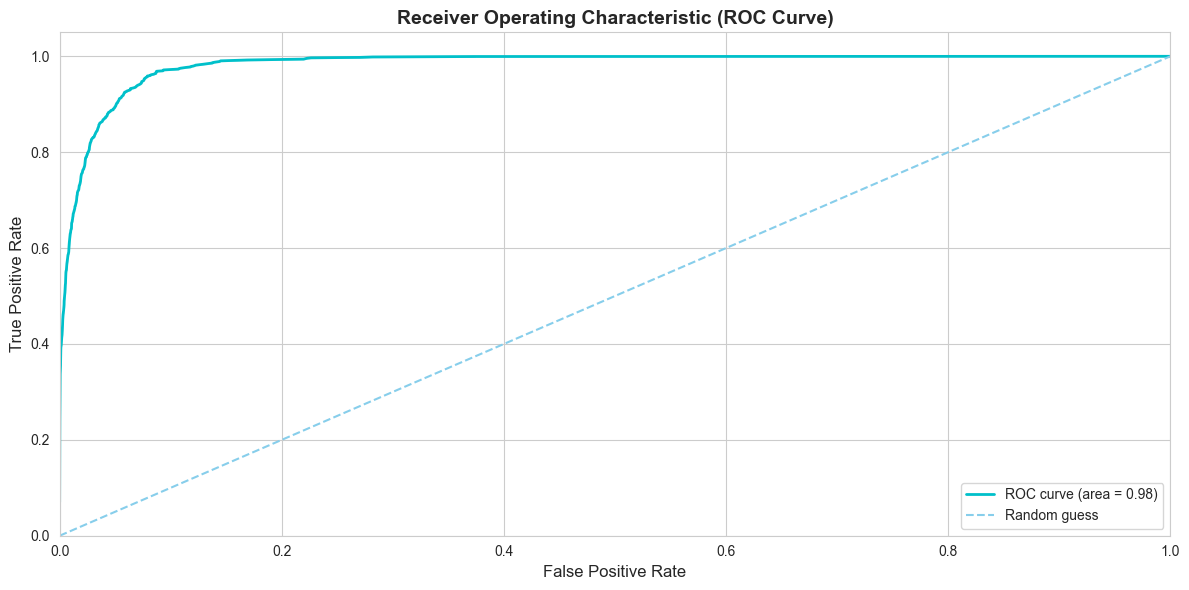

In [80]:

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Plot ROC curve
sns.lineplot(x=fpr, y=tpr, color="#00C0CA", label=f'ROC curve (area = {area:.2f})', linewidth=2)

# Plot the diagonal (random guess line)
sns.lineplot(x=[0, 1], y=[0, 1], color='skyblue', linestyle='--', label='Random guess')

# Set limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC Curve)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


<h4 style = "color:skyblue">Gini Coefficient</h4>

In [81]:
gini_coefficient = 2 * area - 1

print("AUC:", area)
print("Gini Coefficient:", gini_coefficient)

AUC: 0.9829690208967901
Gini Coefficient: 0.9659380417935801


AUC of 0.98: The model is very good at distinguishing between events and non-events.

Gini coefficient of 0.96: This further confirms that the model is highly effective in its predictions, with almost perfect rank ordering capability.

The Gini coefficient ranges from -1 to 1, where a value closer to 1 signifies a perfect model, 0 indicates a model with no discriminative power, and -1 signifies a perfectly incorrect model.

<h3 style = "color:skyblue">Model Evaluation : Rankordering, KS statistic, Gini coeff</h3>

In [82]:
probabilities = best_model_logistic.predict_proba(X_test_encoded)[:,1]

df_eval = pd.DataFrame({
    "Default Truth": y_test,
    "Default Probability": probabilities
}).reset_index(drop="index")

df_eval.head()

,Default Truth,Default Probability
0,0,0.000005
1,0,0.772203
2,0,0.131483
3,0,0.413780
4,0,0.000870


In [83]:
df_eval["Decile"] = pd.qcut(df_eval["Default Probability"], 10, labels= False, duplicates="drop")
df_eval.head()

,Default Truth,Default Probability,Decile
0,0,0.000005,1
1,0,0.772203,8
2,0,0.131483,7
3,0,0.413780,8
4,0,0.000870,5


In [84]:
df_decile = df_eval.groupby("Decile").apply(lambda x: pd.Series({
    "Minimum Probability": x["Default Probability"].min(),
    "Maximum Probability": x["Default Probability"].max(),
    "Events": x["Default Truth"].sum(),
    "Non Events": x["Default Truth"].count() - x["Default Truth"]
.sum()})). reset_index()

df_decile


,Decile,Minimum Probability,Maximum Probability,Events,Non Events
0,0,8.402786e-10,7.132203e-07,0.0,1250.0
1,1,7.136652e-07,5.550836e-06,0.0,1250.0
2,2,5.553892e-06,2.995968e-05,0.0,1250.0
3,3,3.006266e-05,1.598033e-04,0.0,1249.0
4,4,1.601770e-04,7.963232e-04,0.0,1250.0
5,5,7.971383e-04,4.647607e-03,1.0,1249.0
6,6,4.650464e-03,3.040512e-02,2.0,1247.0
7,7,3.041667e-02,2.022569e-01,17.0,1233.0
8,8,2.023410e-01,8.210888e-01,170.0,1080.0
9,9,8.220510e-01,1.000000e+00,918.0,332.0


In [85]:
df_decile["Event Rate"] = (df_decile["Events"] / (df_decile["Events"] + df_decile["Non Events"])) * 100
df_decile["Non Event Rate"] = (df_decile["Non Events"] / (df_decile["Events"] + df_decile["Non Events"])) * 100

df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non Events,Event Rate,Non Event Rate
0,0,8.402786e-10,7.132203e-07,0.0,1250.0,0.000000,100.000000
1,1,7.136652e-07,5.550836e-06,0.0,1250.0,0.000000,100.000000
2,2,5.553892e-06,2.995968e-05,0.0,1250.0,0.000000,100.000000
3,3,3.006266e-05,1.598033e-04,0.0,1249.0,0.000000,100.000000
4,4,1.601770e-04,7.963232e-04,0.0,1250.0,0.000000,100.000000
5,5,7.971383e-04,4.647607e-03,1.0,1249.0,0.080000,99.920000
6,6,4.650464e-03,3.040512e-02,2.0,1247.0,0.160128,99.839872
7,7,3.041667e-02,2.022569e-01,17.0,1233.0,1.360000,98.640000
8,8,2.023410e-01,8.210888e-01,170.0,1080.0,13.600000,86.400000
9,9,8.220510e-01,1.000000e+00,918.0,332.0,73.440000,26.560000


In [86]:
df_decile = df_decile.sort_values(by="Decile", ascending= False). reset_index(drop= True)
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non Events,Event Rate,Non Event Rate
0,9,8.220510e-01,1.000000e+00,918.0,332.0,73.440000,26.560000
1,8,2.023410e-01,8.210888e-01,170.0,1080.0,13.600000,86.400000
2,7,3.041667e-02,2.022569e-01,17.0,1233.0,1.360000,98.640000
3,6,4.650464e-03,3.040512e-02,2.0,1247.0,0.160128,99.839872
4,5,7.971383e-04,4.647607e-03,1.0,1249.0,0.080000,99.920000
5,4,1.601770e-04,7.963232e-04,0.0,1250.0,0.000000,100.000000
6,3,3.006266e-05,1.598033e-04,0.0,1249.0,0.000000,100.000000
7,2,5.553892e-06,2.995968e-05,0.0,1250.0,0.000000,100.000000
8,1,7.136652e-07,5.550836e-06,0.0,1250.0,0.000000,100.000000
9,0,8.402786e-10,7.132203e-07,0.0,1250.0,0.000000,100.000000


In [87]:
df_decile["Cum Events"] = df_decile["Events"].cumsum()
df_decile["Cum Non Events"] = df_decile["Non Events"].cumsum()

df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non Events,Event Rate,Non Event Rate,Cum Events,Cum Non Events
0,9,8.220510e-01,1.000000e+00,918.0,332.0,73.440000,26.560000,918.0,332.0
1,8,2.023410e-01,8.210888e-01,170.0,1080.0,13.600000,86.400000,1088.0,1412.0
2,7,3.041667e-02,2.022569e-01,17.0,1233.0,1.360000,98.640000,1105.0,2645.0
3,6,4.650464e-03,3.040512e-02,2.0,1247.0,0.160128,99.839872,1107.0,3892.0
4,5,7.971383e-04,4.647607e-03,1.0,1249.0,0.080000,99.920000,1108.0,5141.0
5,4,1.601770e-04,7.963232e-04,0.0,1250.0,0.000000,100.000000,1108.0,6391.0
6,3,3.006266e-05,1.598033e-04,0.0,1249.0,0.000000,100.000000,1108.0,7640.0
7,2,5.553892e-06,2.995968e-05,0.0,1250.0,0.000000,100.000000,1108.0,8890.0
8,1,7.136652e-07,5.550836e-06,0.0,1250.0,0.000000,100.000000,1108.0,10140.0
9,0,8.402786e-10,7.132203e-07,0.0,1250.0,0.000000,100.000000,1108.0,11390.0


In [88]:
df_decile["Cum Event Rate"] = (df_decile["Cum Events"] / (df_decile["Events"].sum()) * 100 )
df_decile["Cum Non Event Rate"] = (df_decile["Cum Non Events"] / (df_decile["Non Events"].sum()) * 100 )

df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non Events,Event Rate,Non Event Rate,Cum Events,Cum Non Events,Cum Event Rate,Cum Non Event Rate
0,9,8.220510e-01,1.000000e+00,918.0,332.0,73.440000,26.560000,918.0,332.0,82.851986,2.914838
1,8,2.023410e-01,8.210888e-01,170.0,1080.0,13.600000,86.400000,1088.0,1412.0,98.194946,12.396839
2,7,3.041667e-02,2.022569e-01,17.0,1233.0,1.360000,98.640000,1105.0,2645.0,99.729242,23.222125
3,6,4.650464e-03,3.040512e-02,2.0,1247.0,0.160128,99.839872,1107.0,3892.0,99.909747,34.170325
4,5,7.971383e-04,4.647607e-03,1.0,1249.0,0.080000,99.920000,1108.0,5141.0,100.000000,45.136084
5,4,1.601770e-04,7.963232e-04,0.0,1250.0,0.000000,100.000000,1108.0,6391.0,100.000000,56.110623
6,3,3.006266e-05,1.598033e-04,0.0,1249.0,0.000000,100.000000,1108.0,7640.0,100.000000,67.076383
7,2,5.553892e-06,2.995968e-05,0.0,1250.0,0.000000,100.000000,1108.0,8890.0,100.000000,78.050922
8,1,7.136652e-07,5.550836e-06,0.0,1250.0,0.000000,100.000000,1108.0,10140.0,100.000000,89.025461
9,0,8.402786e-10,7.132203e-07,0.0,1250.0,0.000000,100.000000,1108.0,11390.0,100.000000,100.000000


In [89]:
df_decile["KS"] = abs(df_decile["Cum Event Rate"] - df_decile["Cum Non Event Rate"])

df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non Events,Event Rate,Non Event Rate,Cum Events,Cum Non Events,Cum Event Rate,Cum Non Event Rate,KS
0,9,8.220510e-01,1.000000e+00,918.0,332.0,73.440000,26.560000,918.0,332.0,82.851986,2.914838,79.937148
1,8,2.023410e-01,8.210888e-01,170.0,1080.0,13.600000,86.400000,1088.0,1412.0,98.194946,12.396839,85.798107
2,7,3.041667e-02,2.022569e-01,17.0,1233.0,1.360000,98.640000,1105.0,2645.0,99.729242,23.222125,76.507117
3,6,4.650464e-03,3.040512e-02,2.0,1247.0,0.160128,99.839872,1107.0,3892.0,99.909747,34.170325,65.739422
4,5,7.971383e-04,4.647607e-03,1.0,1249.0,0.080000,99.920000,1108.0,5141.0,100.000000,45.136084,54.863916
5,4,1.601770e-04,7.963232e-04,0.0,1250.0,0.000000,100.000000,1108.0,6391.0,100.000000,56.110623,43.889377
6,3,3.006266e-05,1.598033e-04,0.0,1249.0,0.000000,100.000000,1108.0,7640.0,100.000000,67.076383,32.923617
7,2,5.553892e-06,2.995968e-05,0.0,1250.0,0.000000,100.000000,1108.0,8890.0,100.000000,78.050922,21.949078
8,1,7.136652e-07,5.550836e-06,0.0,1250.0,0.000000,100.000000,1108.0,10140.0,100.000000,89.025461,10.974539
9,0,8.402786e-10,7.132203e-07,0.0,1250.0,0.000000,100.000000,1108.0,11390.0,100.000000,100.000000,0.000000


Key findings:

Strong discrimination: Model effectively separates events from non-events sinces KS statistics peaks at decile 2 85.7%

Decile 1 (highest risk): 73% event rate vs 27% non-event rate
Decile 2: 14% event rate
Deciles 3-10: Nearly all non-events (<2% event rate)


KS Statistic peaks at ~85.7% (Decile 2) - excellent separation between distributions
Model behavior:

Top 2 deciles capture 98% of all events
Bottom 8 deciles are primarily non-events (low false positive rate)
Probability range: 98% down to near 0%



Interpretation: This is a highly effective risk model with strong predictive power. The top deciles concentrate true events while keeping non-events minimal - ideal for prioritizing high-risk cases.

<h3 style  = "color:skyblue">Finalize The Model and Visualize Feature Importance</h3>

In [106]:
final_model = best_model_logistic

feature_importance = final_model.coef_[0]

coef_df = pd.DataFrame(feature_importance, index=X_train_encoded.columns, columns=['Coefficients']).sort_values(by="Coefficients", ascending= False)

coef_df

,Coefficients
loan_to_income,18.286666
credit_utilization_ratio,16.015154
delinquency_ratio,13.614482
avg_dpd_per_delinquency,1.934205
residence_type_Rented,1.897329
loan_purpose_Personal,1.154602
loan_type_Unsecured,1.154602
number_of_open_accounts,1.053105
loan_purpose_Education,0.894390
loan_tenure_months,0.793834


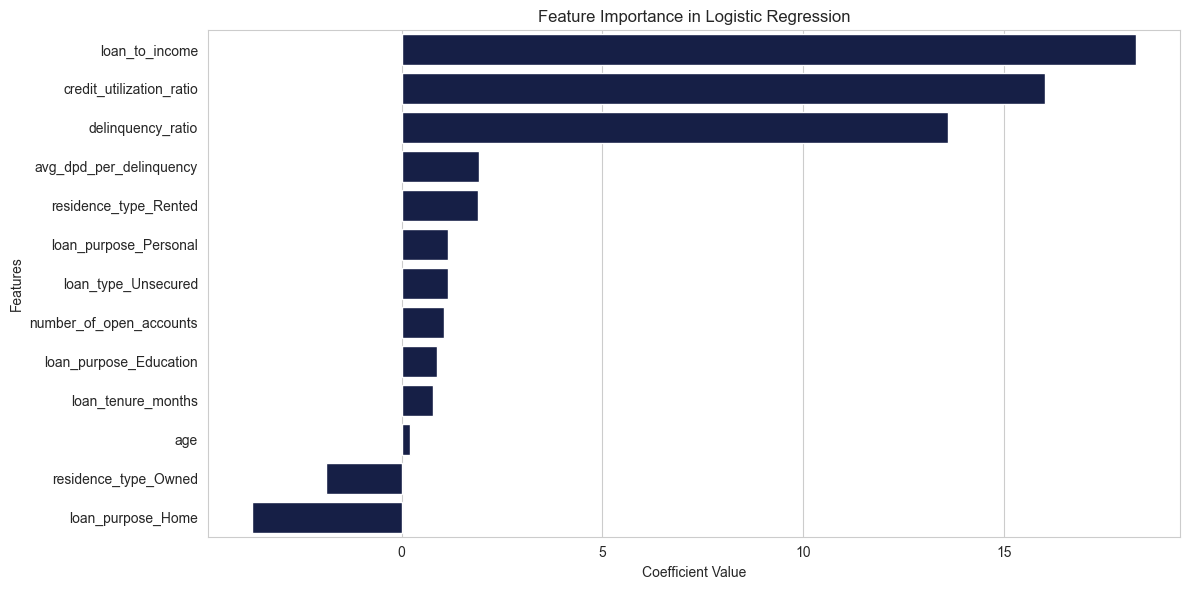

In [108]:
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x = coef_df['Coefficients'], y = coef_df.index, color="#0E1A4E", orient='h')
plt.xlabel('Coefficient Value')
plt.ylabel("Features")
plt.title('Feature Importance in Logistic Regression')
plt.tight_layout()
plt.show()

<h3 style= "color:skyblue">Save the Model</h3>

In [109]:
X_train_encoded.columns

Index(['age', 'loan_tenure_months', 'number_of_open_accounts',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency', 'residence_type_Owned',
       'residence_type_Rented', 'loan_purpose_Education', 'loan_purpose_Home',
       'loan_purpose_Personal', 'loan_type_Unsecured'],
      dtype='object')

In [111]:
cols_to_scale

Index(['age', 'number_of_dependants', 'years_at_current_address',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [113]:
from joblib import dump

model_data = {
    'model': final_model,
    'features': X_train_encoded.columns,
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}

dump(model_data, "../artifacts/model_data.joblib")

['../artifacts/model_data.joblib']

In [114]:
final_model.coef_, final_model.intercept_

(array([[ 0.21533648,  0.79383381,  1.05310486, 16.01515439, 18.28666593,
         13.61448181,  1.93420499, -1.87930855,  1.89732884,  0.89439009,
         -3.72634119,  1.15460167,  1.15460167]]),
 array([-21.12425547]))